In [1]:
import pickle
import sys
sys.path.append("../../spike")
import spike.multirecording_spikeanalysis as spike
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import seaborn as sns
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))
    
import spike.spike_analysis.firing_rate_calculations as fr
import spike.spike_analysis.spike_collection as collection
import spike.spike_analysis.spike_recording as recording

import spike.spike_analysis.pca_trajectories as pca_trajectories
import pickle


In [2]:

def plot_pca_results_3d(pca_result, title, colors, azim, elev, save = False):
    event_lengths = int(
            (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
        )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")
    #plt.subplots_adjust(left=0.3, right=0.99, bottom=0.1, top=0.9)
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pca_result.pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        ax.plot3D(
            PCA_matrix[i : i + event_lengths, 0],
            PCA_matrix[i : i + event_lengths, 1],
            PCA_matrix[i : i + event_lengths, 2],
            label=event_label,
            color=colors[col_counter],
            linewidth = 5,
            alpha = 0.8
        )
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            PCA_matrix[i, 2],
            marker="s",
            s=100,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            PCA_matrix[onset, 2],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            PCA_matrix[end, 2],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                PCA_matrix[post, 2],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
            )
        col_counter += 1
    ax.legend(loc="upper left", bbox_to_anchor=(.9,1), frameon = False, fontsize = 14)
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    # ax.set_zlim(-20, 30)
    ax.view_init(azim = azim, elev =elev)
    ax.set_title(f"{title}", fontsize = 24, y = 1)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_zlabel(f"PC3 ({pc_var[2]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.yaxis.pane.set_alpha(0.9)
    ax.xaxis.pane.set_alpha(0.9)
    ax.zaxis.pane.set_alpha(0.9)
    plt.tight_layout()
    if save:
        plt.savefig(f'{title}.png', dpi = 600, transparent = True,bbox_inches='tight' )
    plt.show()


def plot_pca_results_2d(pca_result, title, colors, legend_spot, save=False):
    event_lengths = int(
        (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
    )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    
    # Create figure with updated size
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    for i in range(0, len(PCA_key), event_lengths):
        event_label = PCA_key[i]
        onset = int(i + pca_result.pre_window - 1)
        end = int(i + event_end - 1)
        post = int(i + event_lengths - 1)
        
        # Plot the continuous line with updated styling
        ax.plot(
            PCA_matrix[i:i + event_lengths, 0],
            PCA_matrix[i:i + event_lengths, 1],
            label=event_label,
            color=colors[col_counter],
            linewidth=5,
            alpha=0.8,
            zorder = 1
        )
        
        # Add markers with updated sizes
        ax.scatter(
            PCA_matrix[i, 0],
            PCA_matrix[i, 1],
            marker="s",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 2
        )
        ax.scatter(
            PCA_matrix[onset, 0],
            PCA_matrix[onset, 1],
            marker="^",
            s=300,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 3
        )
        ax.scatter(
            PCA_matrix[end, 0],
            PCA_matrix[end, 1],
            marker="o",
            s=200,
            c="w",
            edgecolors=colors[col_counter],
            zorder = 4
        )
        if post_window != 0:
            ax.scatter(
                PCA_matrix[post, 0],
                PCA_matrix[post, 1],
                marker="D",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
                zorder =5
            )
        col_counter += 1
    
    # Updated legend formatting
    ax.legend(loc="upper left", bbox_to_anchor=legend_spot, frameon=False, fontsize=14)
    
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    
    # Updated title and label formatting
    ax.set_title(f"{title}", fontsize=24, y=1.01)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize=16)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize=16)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Add tight layout
    plt.tight_layout()
    
    if save:
        plt.savefig(f'{title}.png', dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

In [3]:
cagemate_collection = unpickle_this('cagemate_collection.pkl')
novel_collection = unpickle_this('novel_collection.pkl')


In [101]:
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)
novel_collection.analyze(timebin = 100, ignore_freq=0.5, smoothing_window=500)

All set to analyze
All set to analyze


In [102]:
color_id_dict = {'novel': hex_2_rgb('#15616F'), 
                    'short-term familiar': (1.0, 0.6862745098039216, 0.0),
                    'long-term familiar': hex_2_rgb('#792910')}

In [103]:
cagemate_collection.collection[0].event_dict.keys()

dict_keys(['baseline', 'exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'novel', 'not_novel'])

In [121]:
cagemate_collection.analyze(timebin = 100, ignore_freq=0.5)
novel_collection.analyze(timebin = 100, ignore_freq=0.5)

All set to analyze
All set to analyze


Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons
(350, 261)
(350, 261)
(350, 261)


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


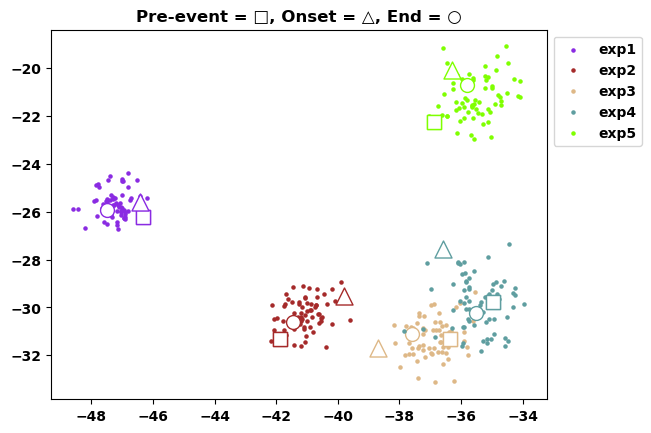

Excluding 33_nov_p1_merged.rec with 1 neurons
(300, 130)
(300, 130)
(300, 130)


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


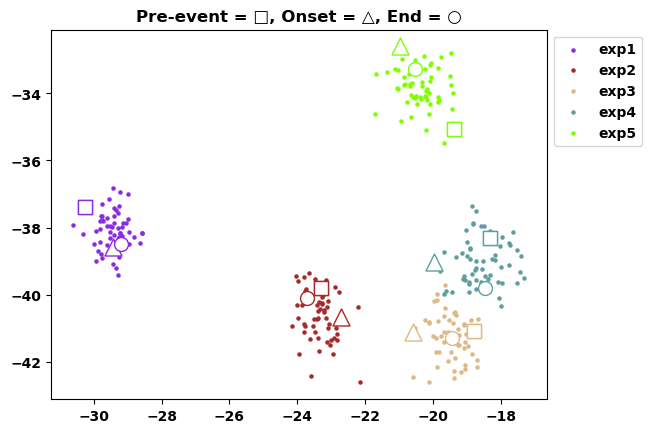

C:\Users\megha\AppData\Local\Temp\ipykernel_12152\4153481633.py:83: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


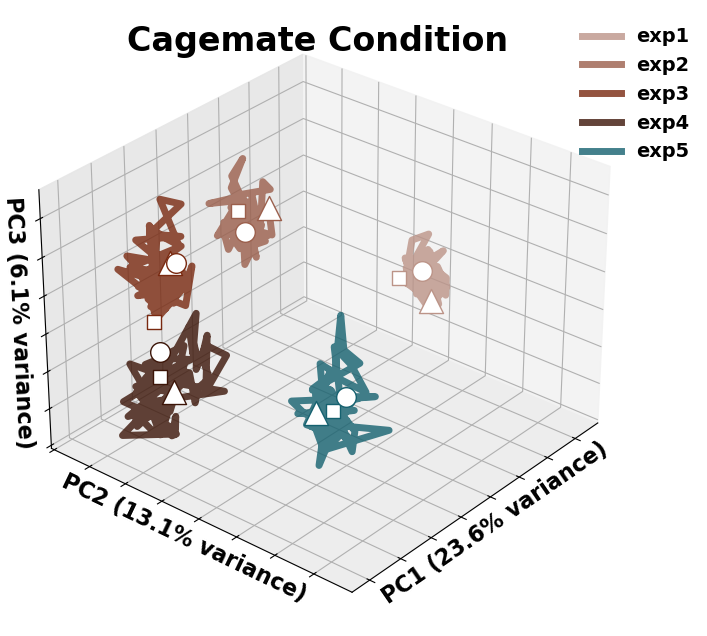

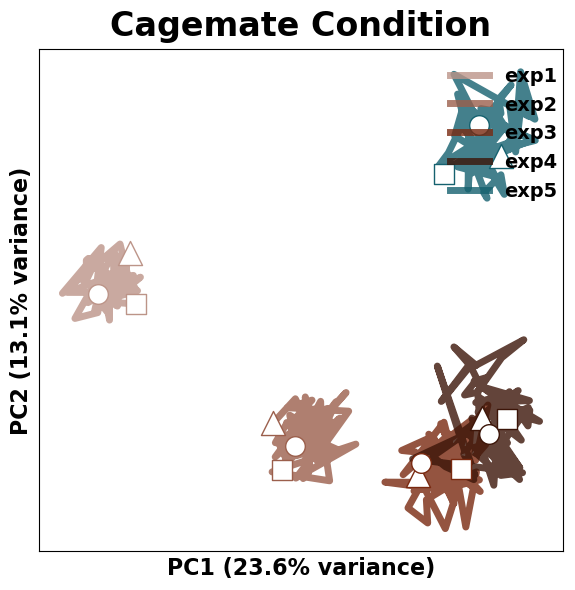

PCA Result with:
Events: exp1, exp2, exp3, exp4, exp5
Timebins per event: 70.0
Total neurons: 261
Number of recordings: 18
Number of Pcs needed to explain 90% of variance 61


In [122]:
import importlib
importlib.reload(pca_trajectories)
cagemate_pca_results = pca_trajectories.avg_trajectories_pca(cagemate_collection, 2, 5, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'],min_neurons=5, plot = True)
novel_pca_results = pca_trajectories.avg_trajectories_pca(novel_collection, 3, 3, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'],min_neurons=5, plot = True)

exp_colors = [hex_2_rgb('#bc9488'),
              hex_2_rgb('#9b5f4c'),
              hex_2_rgb('#792910'),
              hex_2_rgb('#3c1508'),
              hex_2_rgb('#15616F')]
plot_pca_results_3d(cagemate_pca_results, "Cagemate Condition", exp_colors, azim = 40, elev = 30)
plot_pca_results_2d(cagemate_pca_results, "Cagemate Condition", colors = exp_colors, legend_spot = (0.75, 1))
print(cagemate_pca_results)


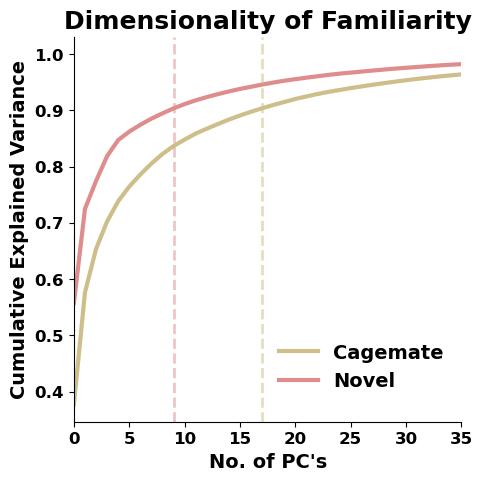

In [110]:
plt.figure(figsize=(5, 5))
plt.plot(cagemate_pca_results.cumulative_variance, label='Cagemate', color = '#CDBE8A', linewidth = 3)
plt.plot(novel_pca_results.cumulative_variance, label='Novel', color = '#DF8C8C', linewidth = 3)
threshold_x1 = None
threshold_x2 = None

for i in range(35):
    if cagemate_pca_results.cumulative_variance[i] > .90 and threshold_x1 is None:
        threshold_x1 = i
    if novel_pca_results.cumulative_variance[i] > .90 and threshold_x2 is None:
        threshold_x2 = i
    if threshold_x1 is not None and threshold_x2 is not None:
        break

# Add vertical dashed lines if thresholds are found
if threshold_x1 is not None:
    plt.axvline(x=threshold_x1, color='#CDBE8A', linestyle='--', alpha=0.5, linewidth = 2)
if threshold_x2 is not None:
    plt.axvline(x=threshold_x2, color='#DF8C8C', linestyle='--', alpha=0.5, linewidth = 2)
plt.xlim(0,35)
plt.legend(frameon=False, fontsize = 14, bbox_to_anchor = (1,0.25))
plt.xlabel("No. of PC's", fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylabel('Cumulative Explained Variance', fontsize = 14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Dimensionality of Familiarity", fontsize = 18)
plt.show()

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


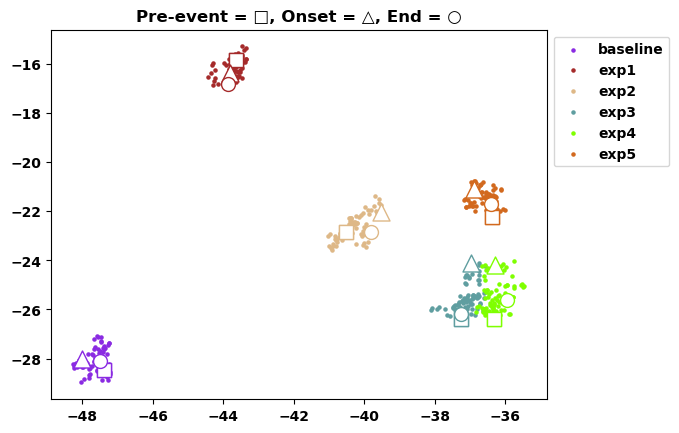

In [11]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, 5, 3, min_neurons=5, plot = True)


In [18]:
import importlib
importlib.reload(pca_trajectories)
cagemate_collection.analyze(timebin = 50, ignore_freq = 0.5)
geo_dist = pca_trajectories.avg_geo_dist(cagemate_collection, 3, 1, percent_var=90, post_window=0, min_neurons = 5)
geo_dist

All set to analyze
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

,baseline_exp1,baseline_exp2,baseline_exp3,baseline_exp4,baseline_exp5,exp1_exp2,exp1_exp3,exp1_exp4,exp1_exp5,exp2_exp3,exp2_exp4,exp2_exp5,exp3_exp4,exp3_exp5,exp4_exp5
11_cage_p1_merged.rec,368.268815,418.664700,443.529026,395.053652,529.745521,303.567356,315.438854,293.596964,409.750232,366.595964,334.870558,440.892736,349.066843,480.119590,443.464747
12_cage_p1_merged.rec,461.785477,572.654912,482.860057,511.319374,485.500712,500.024355,412.224289,413.105682,416.351415,496.604943,488.088026,517.146499,419.072447,434.566565,443.092005
13_cage_p1_merged.rec,290.584844,386.621041,352.540945,362.463804,353.096929,365.594931,342.944289,334.694574,339.106032,411.496875,414.268832,394.009272,403.221484,384.589913,375.541760
21_cage_p1_merged.rec,641.484131,628.860433,664.306885,720.844838,665.112987,475.189559,497.410535,491.959038,455.191325,501.591810,529.393412,521.265340,530.136845,526.545690,507.012484
22_cage_p1_merged.rec,372.070691,372.488901,399.529354,422.372527,456.413971,297.948466,367.458371,404.789387,425.050044,339.772130,398.150215,406.760501,398.736610,444.473105,453.473225
24_cage_p1_merged.rec,379.123198,397.597226,461.252445,388.607028,433.734002,369.204561,414.416690,339.634199,369.218000,350.131572,317.713484,368.490440,327.455232,387.757766,342.170292
32_cage_p1_merged.rec,406.298475,396.444127,469.206638,374.356959,379.890281,360.768806,431.114995,388.366523,389.719522,422.091166,390.282874,381.546577,464.867829,433.910969,373.724871
41_cage_p1_merged.rec,363.348790,360.759078,402.105890,411.624629,483.930982,304.868466,341.228933,336.384904,394.452295,327.067352,332.521361,407.290029,367.144036,393.007699,358.301416
44_cage_p1_merged.rec,420.698673,416.191140,504.508418,544.026960,542.105266,308.874082,410.117874,436.042476,414.485288,392.086835,413.196279,414.858241,513.910536,489.221781,498.761165


In [19]:
from importlib import reload
reload(pca_trajectories)
novel_collection.analyze(timebin = 100, ignore_freq = 0.5, smoothing_window=500)
geo_dist = pca_trajectories.avg_geo_dist(novel_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
avg_vals_df = geo_dist.mean()
avg_vals = avg_vals_df.values.tolist()
avg_sems = geo_dist.sem()
avg_sems = avg_sems.values.tolist()
geo_dist


All set to analyze
Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

,exp1_exp2,exp1_exp3,exp1_exp4,exp1_exp5,exp2_exp3,exp2_exp4,exp2_exp5,exp3_exp4,exp3_exp5,exp4_exp5
11_nov_p1_merged.rec,285.715923,353.636758,364.967783,327.324613,192.842867,241.843598,213.909351,183.836272,203.315374,194.018671
12_nov_p1_merged.rec,167.726340,201.071548,258.468852,151.083641,214.458989,262.381971,214.237055,231.716740,226.295757,259.753579
13_nov_p1_merged.rec,244.674623,235.767665,216.156282,207.282674,134.385077,188.656900,211.897110,170.502215,196.680755,174.279902
21_nov_p1_merged.rec,114.858961,213.450747,215.461223,220.611057,187.295960,208.253979,203.294539,168.402308,162.603622,183.677790
22_nov_p1_merged.rec,241.327097,241.624941,236.785061,194.784208,229.291281,209.153887,237.023596,149.584391,157.202383,147.714826
24_nov_p1_merged.rec,188.517549,191.712638,176.630584,185.357642,159.980343,135.233316,208.427302,147.458820,224.207396,209.793523
32_nov_p1_merged.rec,192.919750,211.867886,196.159408,208.758781,183.396471,185.166175,235.220603,152.506273,218.338705,231.956992
41_nov_p1_merged.rec,248.399961,322.342511,345.566742,406.528170,248.568727,243.785010,329.502316,200.471960,306.181555,251.284944
44_nov_p1_merged.rec,208.916247,289.051129,305.775979,253.448272,219.945398,222.130265,220.083669,157.011565,194.461332,190.890211


In [20]:
novel_geo_dist = pca_trajectories.avg_geo_dist(novel_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
novel_geo_dist
avg_vals_df = novel_geo_dist.mean()
avg_vals_df

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

exp1_exp2    210.339606
exp1_exp3    251.169536
exp1_exp4    257.330213
exp1_exp5    239.464340
exp2_exp3    196.685013
exp2_exp4    210.733900
exp2_exp5    230.399504
exp3_exp4    173.498950
exp3_exp5    209.920764
exp4_exp5    204.818937
dtype: float64

In [21]:
from matplotlib.colors import LinearSegmentedColormap
def create_comparison_matrix(df):
    # Get unique experiments
    experiments = sorted(list(set([exp for col in df.columns for exp in col.split('_')])))
    n = len(experiments)
    
    # Create empty matrix
    matrix = np.zeros((n, n))
    
    # Fill matrix
    for i, exp1 in enumerate(experiments):
        for j, exp2 in enumerate(experiments):
            if i == j:
                matrix[i,j] = 1
            else:
                col1 = f"{exp1}_{exp2}"
                col2 = f"{exp2}_{exp1}"
                if col1 in df.columns:
                    matrix[i,j] = df[col1].mean()
                elif col2 in df.columns:
                    matrix[i,j] = df[col2].mean()
    
    return pd.DataFrame(matrix, index=experiments, columns=experiments)

def plot_comparison_heatmap(df, title, color, diagonal_color, vmin):
    # Create comparison matrix
    matrix = create_comparison_matrix(df)
    
    # Create figure
    plt.figure(figsize=(5, 4))
    n_bins = 100  # Number of color gradients
    cmap = LinearSegmentedColormap.from_list('custom', color, N=n_bins)
    # Create heatmap
    sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt='.0f',
                square=True,
                cbar_kws={'label': 'AU Distance'},
                vmin = vmin)
    for i in range(len(matrix)):
        plt.plot(i + 0.5, i + 0.5, 'o', color=diagonal_color, markersize=25, zorder =100)
    
    plt.title(title, fontsize = 16)
    plt.tight_layout()
    return plt



<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

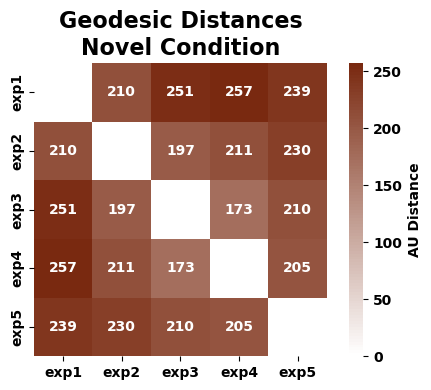

In [23]:
plot_comparison_heatmap(novel_geo_dist, title = "Geodesic Distances\nNovel Condition", color = ['white', '#792910'], diagonal_color='white', vmin = 0)

In [24]:
avg_vals = np.array(avg_vals_df.values.tolist())
avg_vals = avg_vals[[2, 3, 9]]
avg_sems = geo_dist.sem()

avg_sems = np.array(avg_sems.values.tolist())
avg_sems = avg_sems[[2,3,9]]

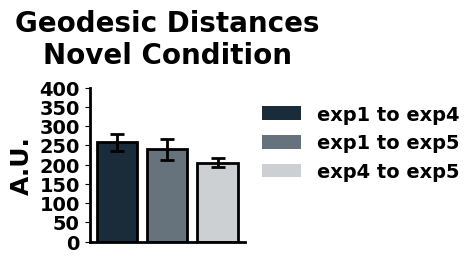

In [27]:

color_id_dict = {'exp1 to exp4': hex_2_rgb('#1a2c3a'),  
                'exp1 to exp5': hex_2_rgb('#66727c'),
                'exp4 to exp5': hex_2_rgb('#ccd0d3')
                }
hatches = ['','','']  
plt.figure(figsize= (2,2))           
plt.bar(color_id_dict.keys(), avg_vals, yerr = avg_sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
plt.ylim(0,400)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Geodesic Distances\nNovel Condition', fontsize = 20, y =1.1)
plt.show()

In [28]:
geo_dist = pca_trajectories.avg_geo_dist(cagemate_collection, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window=1, percent_var=90, post_window=0, min_neurons = 5)
geo_dist
avg_vals_df = geo_dist.mean()
avg_vals_df

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

exp1_exp2    375.896532
exp1_exp3    407.247159
exp1_exp4    396.678732
exp1_exp5    412.789347
exp2_exp3    413.505914
exp2_exp4    415.281919
exp2_exp5    439.223607
exp3_exp4    433.532615
exp3_exp5    454.315290
exp4_exp5    435.825642
dtype: float64

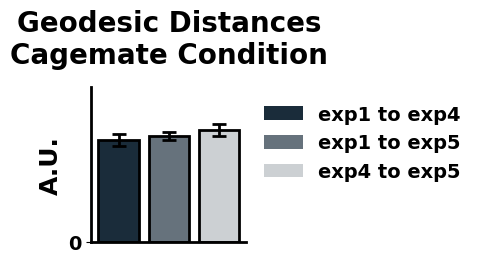

In [30]:
avg_vals = np.array(avg_vals_df.values.tolist())
avg_vals = avg_vals[[2, 3, 9]]
avg_sems = geo_dist.sem()

avg_sems = np.array(avg_sems.values.tolist())
avg_sems = avg_sems[[2,3,9]]
color_id_dict = {'exp1 to exp4': hex_2_rgb('#1a2c3a'),  
                'exp1 to exp5': hex_2_rgb('#66727c'),
                'exp4 to exp5': hex_2_rgb('#ccd0d3')
                }
hatches = ['','','']  
plt.figure(figsize= (2,2))           
plt.bar(color_id_dict.keys(), avg_vals, yerr = avg_sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2, error_kw={'elinewidth': 2, 'capthick': 2})
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(700))
plt.ylim(0,600)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Geodesic Distances\nCagemate Condition', fontsize = 20, y =1.1)
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

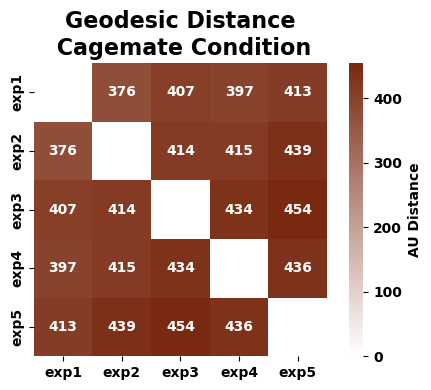

In [31]:
plot_comparison_heatmap(geo_dist, title = "Geodesic Distance\n Cagemate Condition", color = ['white', '#792910'], diagonal_color='white', vmin = 0)


In [33]:

dimensionality = []
for recording in novel_collection.collection:
    pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp5'], event_length=5, pre_window = 3, min_neurons=5, plot = False)
    total_var = 0
    for i in range(len(novel_pc_dict.explained_variance)):
        total_var = total_var + novel_pc_dict.explained_variance[i]
        if total_var > .9:
            dimensionality.append(i)
            break
            

print(np.mean(np.array(dimensionality)))

Excluding 33_nov_p1_merged.rec with 1 neurons
6.0


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

In [35]:
dimensionality = []
for recording in cagemate_collection.collection:
    cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if cagemate_pc_dict:
        for i in range(len(cagemate_pc_dict.explained_variance)):
            total_var = total_var + cagemate_pc_dict.explained_variance[i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
6.777777777777778


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

In [34]:
dimensionality = []
for recording in novel_collection.collection:
    novel_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if novel_pc_dict:
        for i in range(len(novel_pc_dict.explained_variance)):
            total_var = total_var + novel_pc_dict.explained_variance[i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

Excluding 33_nov_p1_merged.rec with 1 neurons
2.888888888888889


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


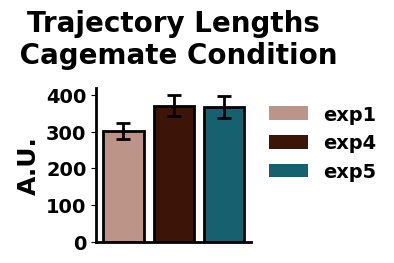

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-3.660282,0.006399,0.019196,True
1,exp1_exp5,-2.490770,0.037477,0.074955,False
2,exp4_exp5,0.142800,0.889979,0.889979,False


In [37]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in cagemate_collection.collection:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,3,4]]
sems_for_plotting = sems[[0,3,4]]

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(300))
# plt.ylim(500,1500)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

Excluding 33_nov_p1_merged.rec with 1 neurons


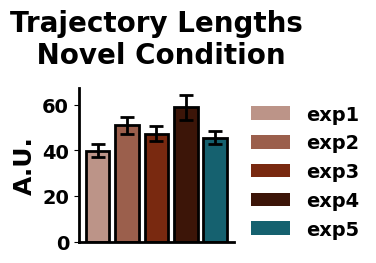

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-3.191525,0.012774,0.038322,True
1,exp1_exp5,-2.724618,0.026062,0.052124,False
2,exp4_exp5,2.620853,0.030610,0.052124,False


In [38]:
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in novel_collection.collection:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                 'exp2' :hex_2_rgb('#9b5f4c'),
                 'exp3': hex_2_rgb('#792910'),
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','', '', '']  
x = [0, 0.5,1,1.5, 2]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(),
            edgecolor = ['black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
# plt.ylim(40,100)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\megha\anaconda3\

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


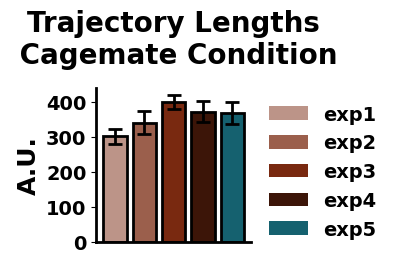

In [39]:
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in cagemate_collection.collection:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                 'exp2' :hex_2_rgb('#9b5f4c'),
                 'exp3': hex_2_rgb('#792910'),
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','', '', '']  
x = [0, 0.5,1,1.5, 2]
plt.figure(figsize= (2,2))           
plt.bar(x, means, yerr = sems,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(200))
# plt.ylim(600,1600)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Cagemate Condition', fontsize = 20, y = 1.1)
plt.show()

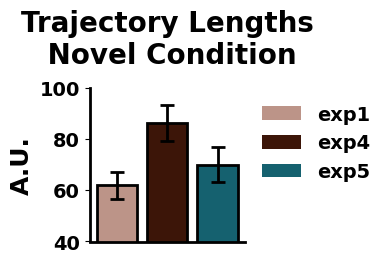

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1_exp4,-3.086491,0.014969,0.044907,True
1,exp1_exp5,-1.960923,0.085536,0.085536,False
2,exp4_exp5,2.530445,0.035231,0.070462,False


In [ ]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def trajectory_length(pca_matrix, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
    for j in range(0, len(key), event_len):
        trajectory_length = 0
        for i in range(event_len-1):
            trajectory_length = trajectory_length + euclidean(
                pca_matrix[j+i, :],
                pca_matrix[j+i+1, :])
        trajectory_lengths.append(trajectory_length)
        event_order.append(key[j])
    return [trajectory_lengths, event_order]

trajectory_lengths = []
orders= []
for recording in novel_collection.collection:
    pc_result = pca_trajectories.avg_trajectories_pca(recording, event_length = 3, pre_window = 1,
                                                 events = ['exp1',
                                                           'exp2',
                                                            'exp3',
                                                           'exp4',
                                                           'exp5'], min_neurons=5, plot = False)
    if pc_result:
        [traj_len, event_order] = trajectory_length(pc_result.transformed_data, pc_result.labels)
        trajectory_lengths.append(traj_len)
        orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)



means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,3,4]]
sems_for_plotting = sems[[0,3,4]]

t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
   't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

# Adjust p-values using Holm-Bonferroni
p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')}
hatches = ['','','']  
x = [0.5,1,1.5]
plt.figure(figsize= (2,2))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(), hatch = hatches,
            edgecolor = ['black', 'black', 'black'],
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = .4)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
plt.ylim(40,100)
hatches = ['//','','','', '']
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


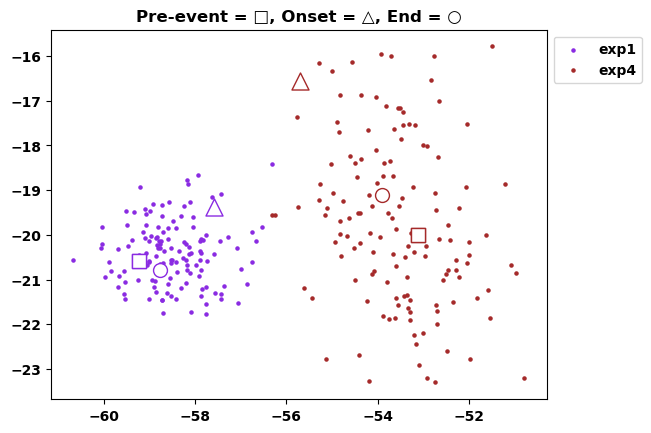

PCA Result with:
Events: exp1, exp4
Timebins per event: 140.0
Total neurons: 134
Number of recordings: 11
Number of Pcs needed to explain 90% of variance 39


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


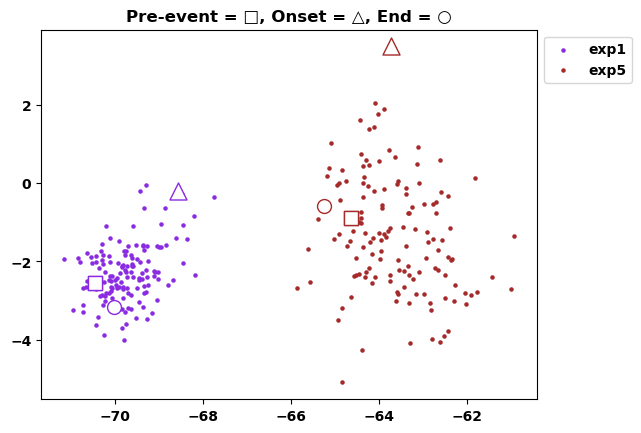

PCA Result with:
Events: exp1, exp5
Timebins per event: 140.0
Total neurons: 134
Number of recordings: 11
Number of Pcs needed to explain 90% of variance 38


In [40]:
reload(pca_trajectories)
print(pca_trajectories.avg_trajectories_pca(cagemate_collection, 4,3, 0, events = ['exp1', 'exp4']))
print(pca_trajectories.avg_trajectories_pca(cagemate_collection, 4,3, 0, events = ['exp1', 'exp5']))

In [41]:
import spike.spike_analysis.decoders as decoders 
num_fold = 5
event_length = 4
pre_window = 3
post_window = 0
min_neurons = 5


cagemate_1v4_results = decoders.trial_decoder(cagemate_collection,
                                              num_fold = num_fold,
                                              no_PCs = 14,
                                              events = ['exp1', 'exp4'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

cagemate_1v5_results = decoders.trial_decoder(cagemate_collection,
                                              num_fold = num_fold,
                                              no_PCs = 9,
                                              events = ['exp1', 'exp5'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


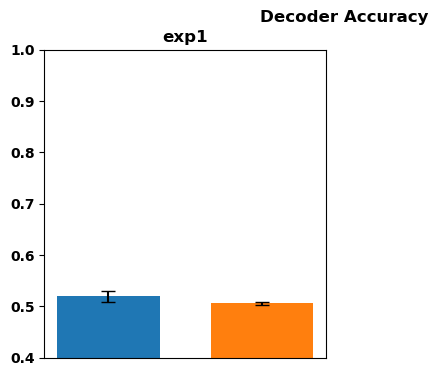

In [42]:
cagemate_1v4_results.plot_average()

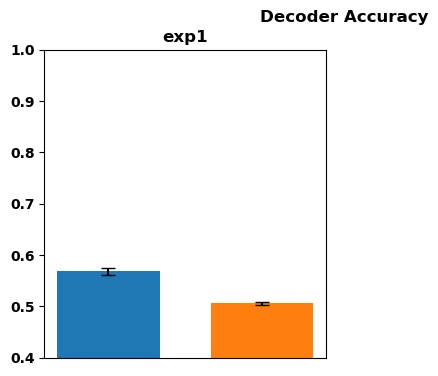

In [43]:
cagemate_1v5_results.plot_average()

c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


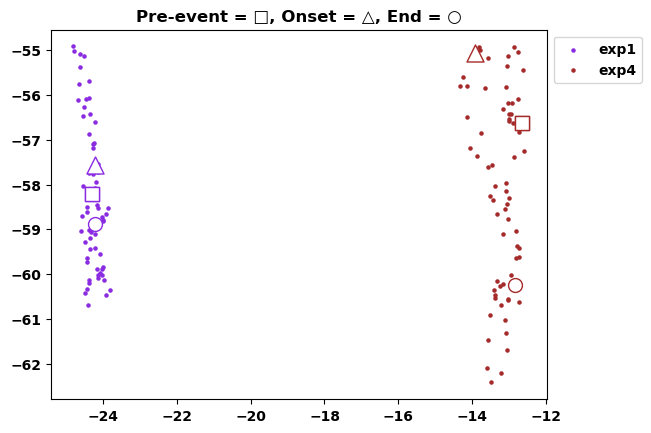

PCA Result with:
Events: exp1, exp4
Timebins per event: 70.0
Total neurons: 131
Number of recordings: 10
Number of Pcs needed to explain 90% of variance 4


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


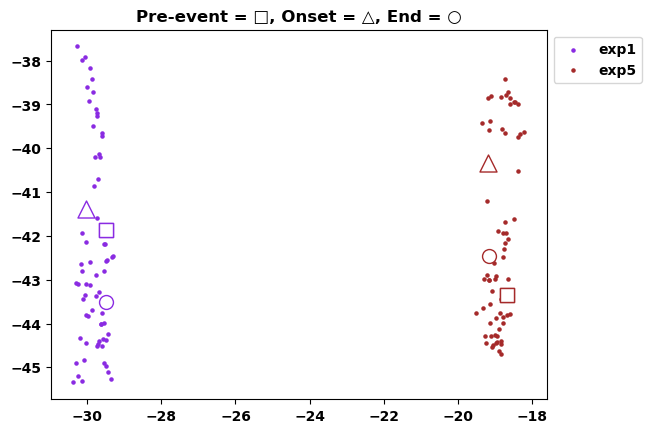

PCA Result with:
Events: exp1, exp5
Timebins per event: 70.0
Total neurons: 131
Number of recordings: 10
Number of Pcs needed to explain 90% of variance 4


In [44]:
print(pca_trajectories.avg_trajectories_pca(novel_collection, 4,3, 0, events = ['exp1', 'exp4']))
print(pca_trajectories.avg_trajectories_pca(novel_collection, 4,3, 0, events = ['exp1', 'exp5']))

In [45]:
novel_1v4_results = decoders.trial_decoder(novel_collection,
                                              num_fold = num_fold,
                                              no_PCs = 4,
                                              events = ['exp1', 'exp4'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

novel_1v5_results = decoders.trial_decoder(novel_collection,
                                              num_fold = num_fold,
                                              no_PCs = 4,
                                              events = ['exp1', 'exp5'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Excluding 33_nov_p1_merged.rec with 1 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


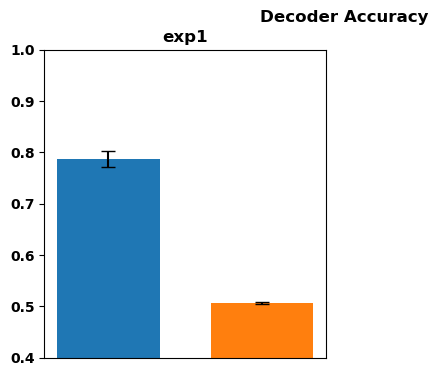

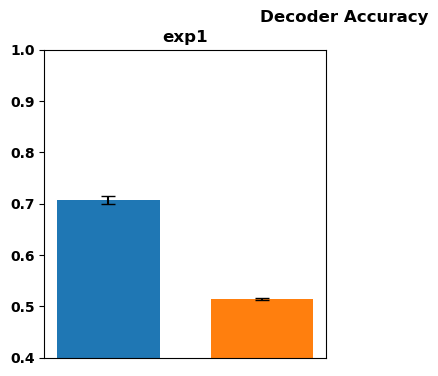

In [46]:
novel_1v4_results.plot_average()
novel_1v5_results.plot_average()

In [47]:
for recording in novel_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel
for recording in cagemate_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel

In [48]:
print(pca_trajectories.avg_trajectories_pca(novel_collection, 4,3, 0, events = ['novel', 'not_novel'], plot = False))
print(pca_trajectories.avg_trajectories_pca(cagemate_collection, 4,3, 0, events = ['novel', 'not_novel'], plot = False))

c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


PCA Result with:
Events: novel, not_novel
Timebins per event: 70.0
Total neurons: 131
Number of recordings: 10
Number of Pcs needed to explain 90% of variance 5
PCA Result with:
Events: novel, not_novel
Timebins per event: 140.0
Total neurons: 134
Number of recordings: 11
Number of Pcs needed to explain 90% of variance 39


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [49]:
novel_novel_results = decoders.trial_decoder(novel_collection,
                                              num_fold = num_fold,
                                              no_PCs = 5,
                                              events = ['novel', 'not_novel'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

cagemate_novel_results = decoders.trial_decoder(cagemate_collection,
                                              num_fold = num_fold,
                                              no_PCs = 14,
                                              events = ['novel', 'not_novel'],
                                              event_length = event_length,
                                              pre_window = pre_window,
                                              post_window = post_window,
                                              min_neurons = min_neurons,
                                              plot = False)

c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Excluding 33_nov_p1_merged.rec with 1 neurons
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


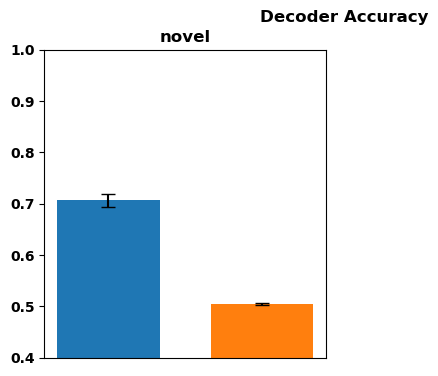

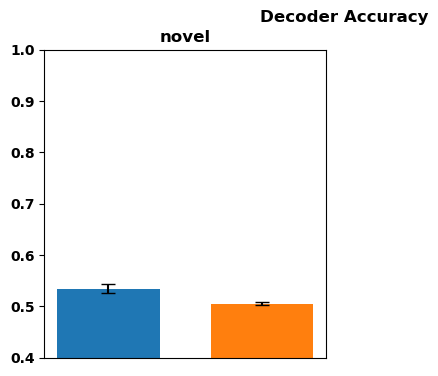

In [50]:
novel_novel_results.plot_average()
cagemate_novel_results.plot_average()

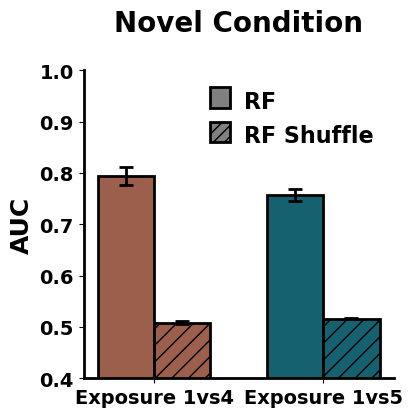

In [51]:
from matplotlib.patches import Patch
def plot_multiple_decoders(decoder_results, title, color_list, legend_titles, figsize, start=0, stop=None, ):
    bar_width = 0.2
    plt.figure(figsize=figsize)
    
    bar_position = 0  # Starting position for bars
    bar_centers = []  # Store center positions for labels
    j = 0
    
    # First, create bars without labels
    for decoder in decoder_results:
        key = list(decoder.results.keys())[0]
        results = list(decoder.results.values())[0]
        
        total_event = decoder.event_length + decoder.post_window
        x = np.linspace(-decoder.pre_window, total_event, np.array(results.roc_auc).shape[0])
        
        if start is not None:
            plot_start = np.where(x >= start)[0][0]
        if stop is None:
            plot_stop = results.roc_auc.shape[0]
        if stop is not None:
            plot_stop = np.where(x <= stop)[0][-1] + 1
            
        rf_avg = np.mean(np.mean(results.roc_auc[start:stop], axis=0), axis=0)
        rf_sem = sem(np.mean(results.roc_auc[plot_start:plot_stop], axis=0))
        rf_shuffle_avg = np.mean(np.mean(results.roc_auc_shuffle[plot_start:plot_stop], axis=0), axis=0)
        rf_shuffle_sem = sem(np.mean(results.roc_auc_shuffle[plot_start:plot_stop], axis=0))
        
        # Plot bars without labels
        plt.bar(bar_position, rf_avg, bar_width, 
               yerr=rf_sem, capsize=5, color=color_list[j], 
               edgecolor='black', linewidth=2,
               error_kw={'elinewidth': 2, 'capthick': 2})
        plt.bar(bar_position + bar_width, rf_shuffle_avg, bar_width, 
               yerr=rf_shuffle_sem, capsize=5, color=color_list[j], 
               hatch='//', edgecolor='black', linewidth=2,
               error_kw={'elinewidth': 2, 'capthick': 2})
        
        # Store center position for this pair of bars
        bar_centers.append(bar_position + bar_width/2)
        
        bar_position += 0.6
        j += 1
    
    # Add centered labels under each pair of bars
    plt.xticks(bar_centers, legend_titles, fontsize=12)
    
    # Create custom legend for RF and RF Shuffle
    legend_elements = [
    Patch(facecolor='grey', edgecolor='black', linewidth=2, label='RF'),
    Patch(facecolor='grey', edgecolor='black', linewidth=2, hatch='///', label='RF Shuffle')
    ]

    # Create the legend with modified properties
    leg = plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1), 
                    frameon=False, fontsize=16)

# Adjust the size of the patches in the legend
    for patch in leg.get_patches():
        patch.set_height(15)  # Adjust this value to change height
        patch.set_y(0)
        patch.set_width(15) 
        patch.set_x(20)
    
    plt.ylim(0.4, 1)
    plt.ylabel('AUC', fontsize=18)
    plt.xticks(fontsize = 14)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.title(title, fontsize=20, y = 1.1)
    plt.yticks(fontsize=14)
    plt.show()

plot_multiple_decoders([novel_1v4_results, novel_1v5_results], title = "Novel Condition", color_list = ['#9b5f4c','#15616F'], start = 0 , stop = 3, legend_titles = ['Exposure 1vs4', 'Exposure 1vs5'], figsize = (4,4))

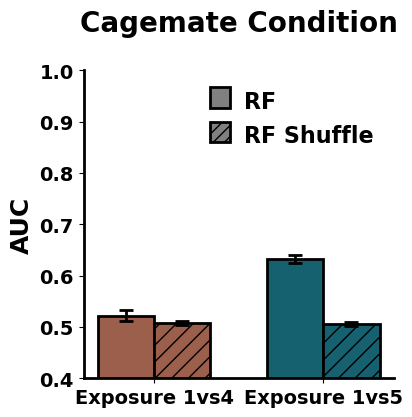

In [52]:
plot_multiple_decoders([cagemate_1v4_results, cagemate_1v5_results], title = "Cagemate Condition", color_list = ['#9b5f4c','#15616F'], start = 0 , stop = 3, legend_titles = ['Exposure 1vs4', 'Exposure 1vs5'], figsize = (4,4))

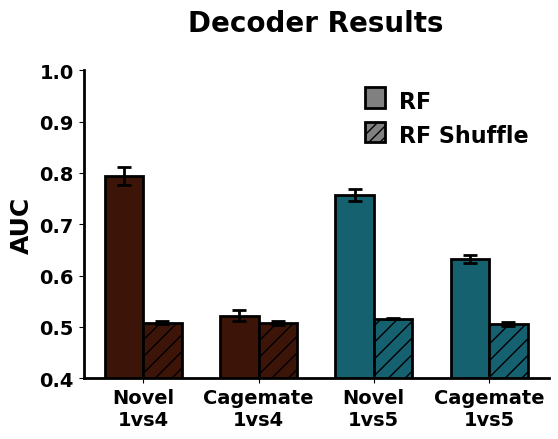

In [53]:
plot_multiple_decoders([novel_1v4_results, cagemate_1v4_results, novel_1v5_results, cagemate_1v5_results], title = "Decoder Results", color_list = ['#3c1508','#3c1508','#15616F','#15616F'], start = 0 , stop = 3, legend_titles = ['Novel\n1vs4', 'Cagemate\n1vs4', 'Novel\n1vs5', 'Cagemate\n1vs5'], figsize = (6,4))

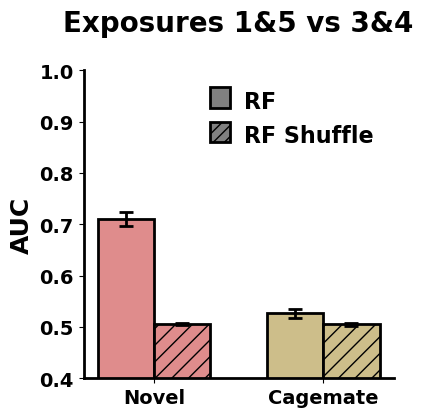

In [54]:
plot_multiple_decoders([novel_novel_results, cagemate_novel_results], title = "Exposures 1&5 vs 3&4", color_list = ['#DF8C8C','#CDBE8A'], start = 0 , stop = 3, legend_titles = ['Novel', 'Cagemate'], figsize = (4,4))

In [55]:

dimensionality = []
for recording in cagemate_collection.collection:
    cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(recording, events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'], event_length=3, pre_window = 1, min_neurons=5, plot = False)
    total_var = 0
    if cagemate_pc_dict:
        for i in range(len(cagemate_pc_dict['explained variance'])):
            total_var = total_var + cagemate_pc_dict['explained variance'][i]
            if total_var > .9:
                dimensionality.append(i)
                break
            

print(np.mean(np.array(dimensionality)))

c:\Users\megha\anaconda3\envs\lfp_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


TypeError: 'PCAResult' object is not subscriptable

Excluding 33_nov_p1_merged.rec with 1 neurons


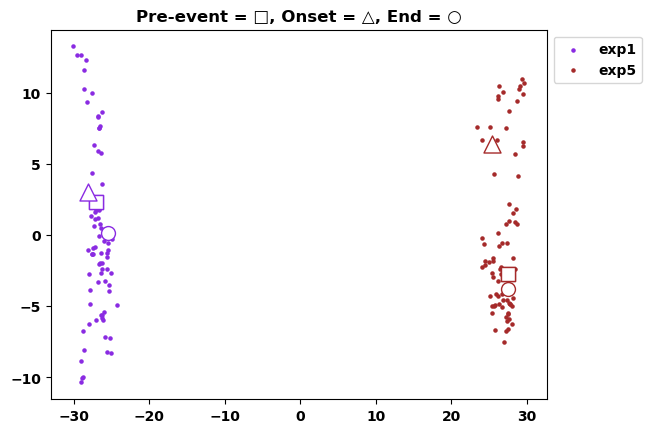

3


In [ ]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, events = ['exp1', 'exp5'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = novel_pc_dict['explained variance']
total_var = 0
for i in range(len(novel_pc_dict['explained variance'])):
    total_var = total_var + novel_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

In [ ]:
for recording in novel_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel
for recording in cagemate_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel

Excluding 33_nov_p1_merged.rec with 1 neurons


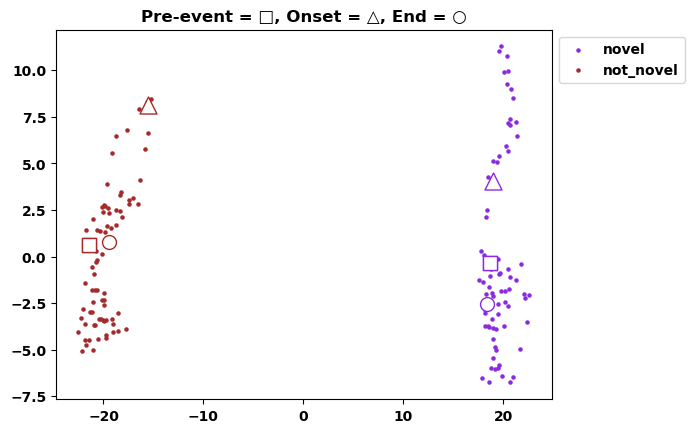

4


In [ ]:
novel_pc_dict = pca_trajectories.avg_trajectories_pca(novel_collection, events = ['novel', 'not_novel'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = novel_pc_dict['explained variance']
total_var = 0
for i in range(len(novel_pc_dict['explained variance'])):
    total_var = total_var + novel_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


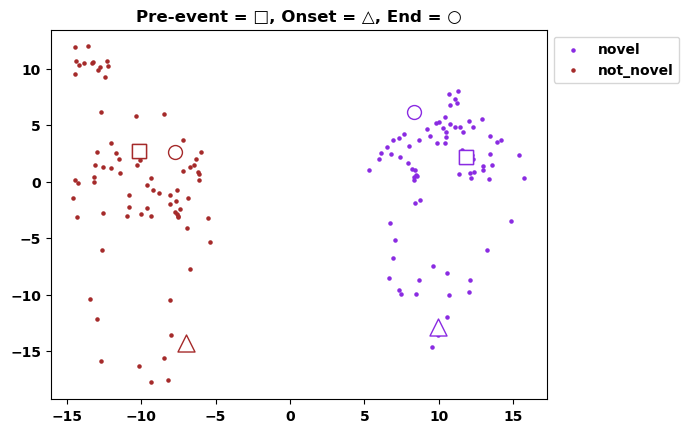

13


In [ ]:
cagemate_pc_dict = pca_trajectories.avg_trajectories_pca(cagemate_collection, events = ['novel', 'not_novel'], event_length=5, pre_window = 3, min_neurons=5, plot = True)
var = cagemate_pc_dict['explained variance']
total_var = 0
for i in range(len(cagemate_pc_dict['explained variance'])):
    total_var = total_var + cagemate_pc_dict['explained variance'][i]
    if total_var > .9:
        print(i)
        break

In [56]:
cagemate_collection = unpickle_this('cagemate_collection.pkl')
novel_collection = unpickle_this('novel_collection.pkl')

In [57]:

whole_collection = 0
whole_collection = cagemate_collection

In [58]:

for recording in novel_collection.collection:
    whole_collection.collection.append(recording)


In [59]:
print(len(whole_collection.collection))

21


In [60]:
for recording in whole_collection.collection:
    print(recording.name)

11_cage_p1_merged.rec
12_cage_p1_merged.rec
13_cage_p1_merged.rec
21_cage_p1_merged.rec
22_cage_p1_merged.rec
24_cage_p1_merged.rec
31_cage_p1_merged.rec
32_cage_p1_merged.rec
33_cage_p1_merged.rec
41_cage_p1_merged.rec
44_cage_p1_merged.rec
11_nov_p1_merged.rec
12_nov_p1_merged.rec
13_nov_p1_merged.rec
21_nov_p1_merged.rec
22_nov_p1_merged.rec
24_nov_p1_merged.rec
32_nov_p1_merged.rec
33_nov_p1_merged.rec
41_nov_p1_merged.rec
44_nov_p1_merged.rec


In [61]:
for recording in whole_collection.collection:
    novel = np.concatenate([recording.event_dict['exp1'], recording.event_dict['exp5']], axis = 0)
    recording.event_dict['novel'] = novel
    not_novel = np.concatenate([recording.event_dict['exp3'], recording.event_dict['exp4']], axis = 0)
    recording.event_dict['not_novel'] = not_novel

In [62]:
condition_dict = {"cagemate": [], "novel": []}
for recording in whole_collection.collection:
    if "cage" in recording.name:
        condition_dict["cagemate"].append(recording.name)
    if "nov" in recording.name:
        condition_dict["novel"].append(recording.name)
print(condition_dict)

{'cagemate': ['11_cage_p1_merged.rec', '12_cage_p1_merged.rec', '13_cage_p1_merged.rec', '21_cage_p1_merged.rec', '22_cage_p1_merged.rec', '24_cage_p1_merged.rec', '31_cage_p1_merged.rec', '32_cage_p1_merged.rec', '33_cage_p1_merged.rec', '41_cage_p1_merged.rec', '44_cage_p1_merged.rec'], 'novel': ['11_nov_p1_merged.rec', '12_nov_p1_merged.rec', '13_nov_p1_merged.rec', '21_nov_p1_merged.rec', '22_nov_p1_merged.rec', '24_nov_p1_merged.rec', '32_nov_p1_merged.rec', '33_nov_p1_merged.rec', '41_nov_p1_merged.rec', '44_nov_p1_merged.rec']}


In [63]:
reload(pca_trajectories)

<module 'spike.spike_analysis.pca_trajectories' from 'c:\\Users\\megha\\Documents\\GitHub\\diff_fam_social_memory_ephys\\spike\\spike_analysis\\pca_trajectories.py'>

In [64]:
pca_result = pca_trajectories.avg_trajectories_pca(whole_collection, event_length=4, pre_window = 1, post_window=0, min_neurons=5, plot= False)

AttributeError: 'SpikeCollection' object has no attribute 'timebin'

In [65]:
pca_result.matrix_df[condition_dict['cagemate']]

NameError: name 'pca_result' is not defined

All set to analyze
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


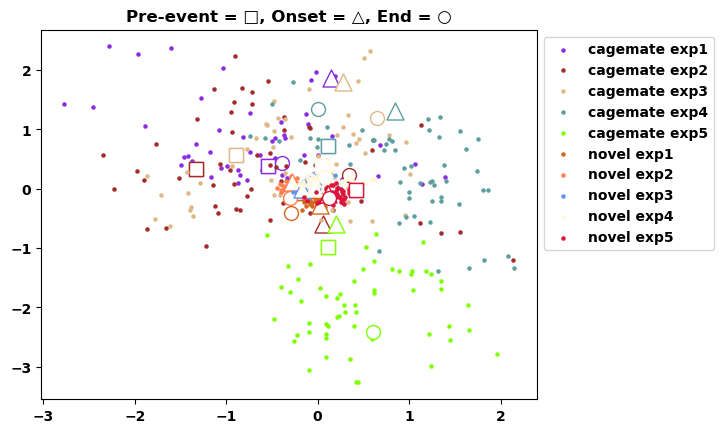

In [74]:
from importlib import reload
reload(pca_trajectories)
events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5']
#events = ['novel', 'not_novel']
event_length=3
pre_window = 3
post_window=0
min_neurons=5
plot= False
whole_collection.analyze(timebin = 100, smoothing_window=500, ignore_freq=0.5)
pca_result = pca_trajectories.coniditon_pca(whole_collection, condition_dict,events = events, event_length=event_length, pre_window=pre_window, min_neurons=min_neurons, plot=True)

In [ ]:
print(pca_result)

PCA Result with:
Events: exp1, exp2, exp3, exp4, exp5
Timebins per event: 60.0
Total neurons: 261
Number of recordings: 18
Number of Pcs needed to explain 90% of variance 18


In [77]:
def plot_condition_results_3d(pca_result, title, colors, azim, elev, save = False):
    event_lengths = int(
            (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
        )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection="3d")
    #plt.subplots_adjust(left=0.3, right=0.99, bottom=0.1, top=0.9)
    for condition in condition_dict.keys():
        for i in range(0, len(PCA_key), event_lengths):
            event_label = PCA_key[i]
            onset = int(i + pca_result.pre_window - 1)
            end = int(i + event_end - 1)
            post = int(i + event_lengths - 1)
            ax.plot3D(
                PCA_matrix[condition][i : i + event_lengths, 0],
                PCA_matrix[condition][i : i + event_lengths, 1],
                PCA_matrix[condition][i : i + event_lengths, 2],
                label=f"{condition} {event_label}",
                color=colors[col_counter],
                linewidth = 5,
                alpha = 0.8
            )
            ax.scatter(
                PCA_matrix[condition][i, 0],
                PCA_matrix[condition][i, 1],
                PCA_matrix[condition][i, 2],
                marker="s",
                s=100,
                c="w",
                edgecolors=colors[col_counter],
            )
            ax.scatter(
                PCA_matrix[condition][onset, 0],
                PCA_matrix[condition][onset, 1],
                PCA_matrix[condition][onset, 2],
                marker="^",
                s=300,
                c="w",
                edgecolors=colors[col_counter],
            )
            ax.scatter(
                PCA_matrix[condition][end, 0],
                PCA_matrix[condition][end, 1],
                PCA_matrix[condition][end, 2],
                marker="o",
                s=200,
                c="w",
                edgecolors=colors[col_counter],
            )
            if post_window != 0:
                ax.scatter(
                    PCA_matrix[condition][post, 0],
                    PCA_matrix[condition][post, 1],
                    PCA_matrix[condition][post, 2],
                    marker="D",
                    s=200,
                    c="w",
                    edgecolors=colors[col_counter],
                )
            col_counter += 1
    ax.legend(loc="upper left", bbox_to_anchor=(.9,1), frameon = False, fontsize = 14)
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    # ax.set_zlim(-20, 30)
    ax.view_init(azim = azim, elev =elev)
    ax.set_title(f"{title}", fontsize = 24, y = 1)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_zlabel(f"PC3 ({pc_var[2]*100:.1f}% variance)", fontsize = 16, labelpad = -10)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.yaxis.pane.set_alpha(0.9)
    ax.xaxis.pane.set_alpha(0.9)
    ax.zaxis.pane.set_alpha(0.9)
    plt.tight_layout()
    if save:
        plt.savefig(f'{title}.png', dpi = 600, transparent = True,bbox_inches='tight' )
    plt.show()


def plot_condition_results_2d(pca_result, title, colors, legend_spot, include_cagemate = True, xlim = None, ylim = None,save=False):
    event_lengths = int(
        (pca_result.event_length + pca_result.pre_window + pca_result.post_window) * 1000 / pca_result.timebin
    )
    
    event_end = int((pca_result.event_length + pca_result.pre_window) * 1000 / pca_result.timebin)
    pre_window = pca_result.pre_window * 1000 / pca_result.timebin
    post_window = pca_result.post_window * 1000 / pca_result.timebin
    pc_var = pca_result.explained_variance
    PCA_key = pca_result.labels
    PCA_matrix = pca_result.transformed_data
    col_counter = 0
    
    # Create figure with updated size
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    for condition in condition_dict.keys():
        if not include_cagemate and condition == 'cagemate':
            pass
        else:
            for i in range(0, len(PCA_key), event_lengths):
                event_label = PCA_key[i]
                onset = int(i + pca_result.pre_window - 1)
                end = int(i + event_end - 1)
                post = int(i + event_lengths - 1)
                
                # Plot the continuous line with updated styling
                ax.plot(
                    PCA_matrix[condition][i:i + event_lengths, 0],
                    PCA_matrix[condition][i:i + event_lengths, 1],
                    label=event_label if condition == 'cagemate' else None,
                    color=colors[col_counter],
                    linewidth=5,
                    alpha=0.8,
                    zorder = 1
                )
                
                # Add markers with updated sizes
                ax.scatter(
                    PCA_matrix[condition][i, 0],
                    PCA_matrix[condition][i, 1],
                    marker="s",
                    s=200,
                    c="w",
                    edgecolors=colors[col_counter],
                    zorder = 2
                )
                ax.scatter(
                    PCA_matrix[condition][onset, 0],
                    PCA_matrix[condition][onset, 1],
                    marker="^",
                    s=300,
                    c="w",
                    edgecolors=colors[col_counter],
                    zorder = 3
                )
                ax.scatter(
                    PCA_matrix[condition][end, 0],
                    PCA_matrix[condition][end, 1],
                    marker="o",
                    s=200,
                    c="w",
                    edgecolors=colors[col_counter],
                    zorder = 4
                )
                if post_window != 0:
                    ax.scatter(
                        PCA_matrix[condition][post, 0],
                        PCA_matrix[condition][post, 1],
                        marker="D",
                        s=200,
                        c="w",
                        edgecolors=colors[col_counter],
                        zorder =5
                    )
                col_counter += 1
        
    # Updated legend formatting
    ax.legend(loc="upper left", bbox_to_anchor=legend_spot, frameon=False, fontsize=14)
    
    # ax.set_xlim(-20, 45)
    # ax.set_ylim(-5, 25)
    
    # Updated title and label formatting
    ax.set_title(f"{title}", fontsize=24, y=1.01)
    ax.set_xlabel(f"PC1 ({pc_var[0]*100:.1f}% variance)", fontsize=16)
    ax.set_ylabel(f"PC2 ({pc_var[1]*100:.1f}% variance)", fontsize=16)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None: 
        ax.set_xlim(xlim)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Add tight layout
    plt.tight_layout()
    
    if save:
        plt.savefig(f'{title}.png', dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

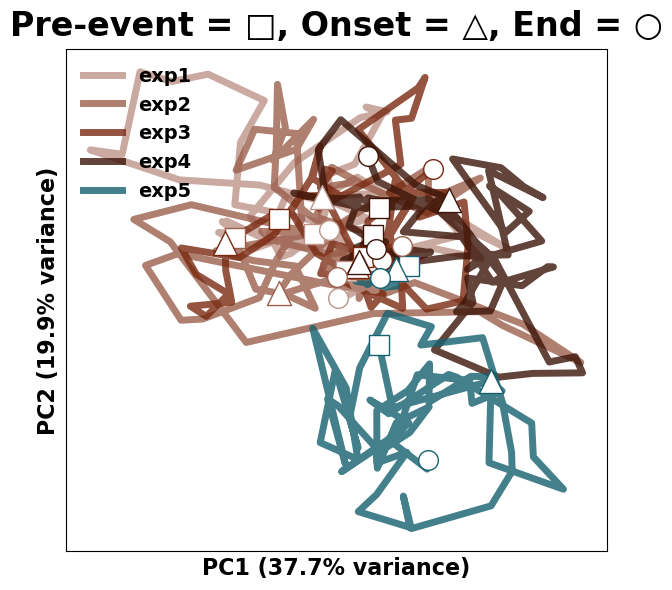

C:\Users\megha\AppData\Local\Temp\ipykernel_12152\3380868870.py:168: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left", bbox_to_anchor=legend_spot, frameon=False, fontsize=14)


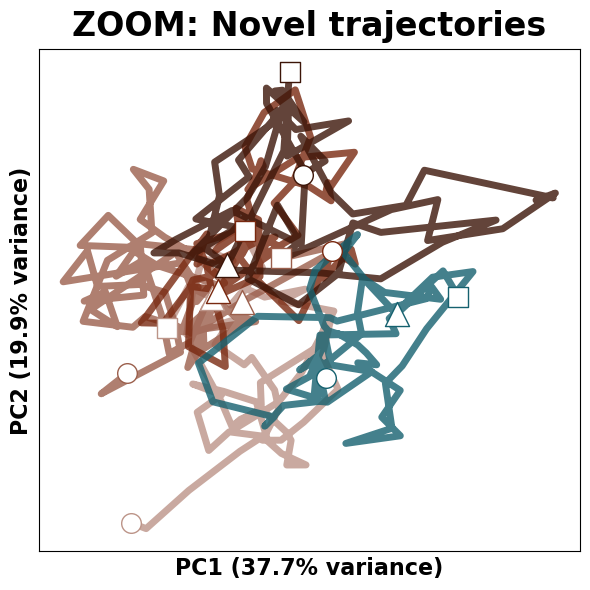

In [79]:



exp_colors = [hex_2_rgb('#bc9488'),
              hex_2_rgb('#9b5f4c'),
              hex_2_rgb('#792910'),
              hex_2_rgb('#3c1508'),
              hex_2_rgb('#15616F'),
              hex_2_rgb('#bc9488'),
              hex_2_rgb('#9b5f4c'),
              hex_2_rgb('#792910'),
              hex_2_rgb('#3c1508'),
              hex_2_rgb('#15616F')]

title = "Pre-event = □, Onset = △, End = ○" 
plot_condition_results_2d(pca_result=pca_result, title = title, colors = exp_colors, legend_spot = (0, 1))
plot_condition_results_2d(pca_result=pca_result, title = 'ZOOM: Novel trajectories', colors = exp_colors, legend_spot = (0, 1),  include_cagemate = False)

11_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


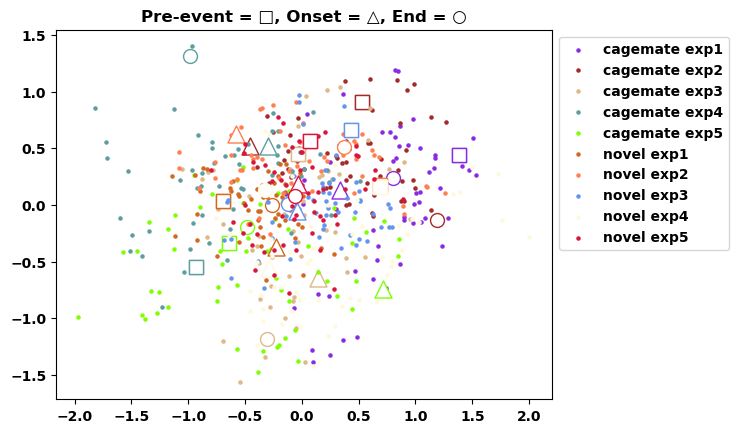

12_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


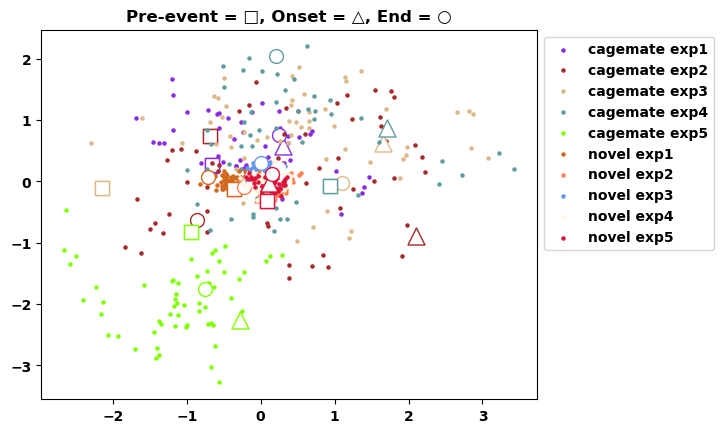

13_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


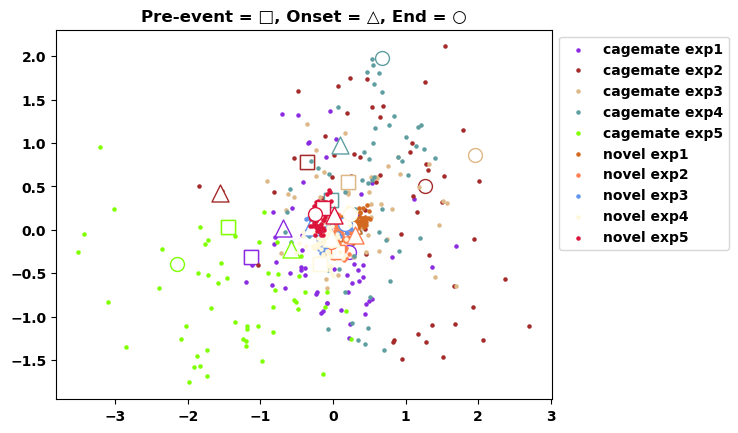

21_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


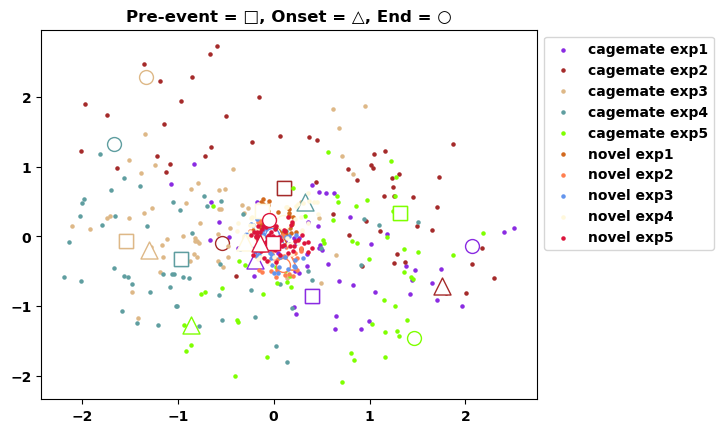

22_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


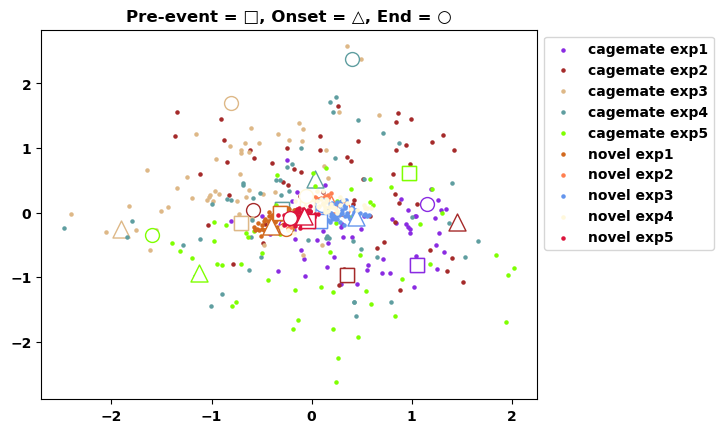

24_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


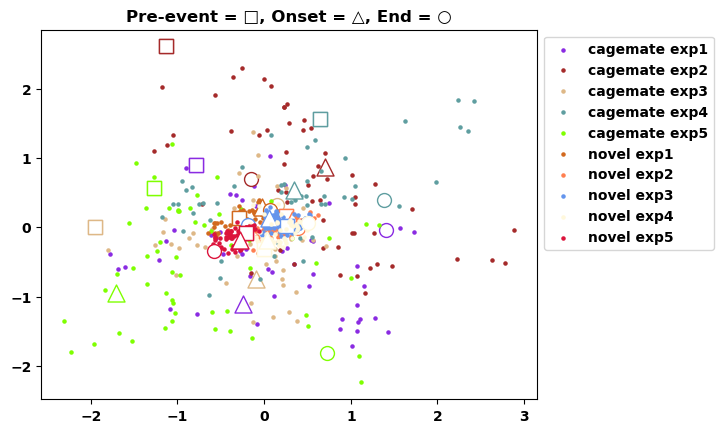

31_cage_p1_merged.rec
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


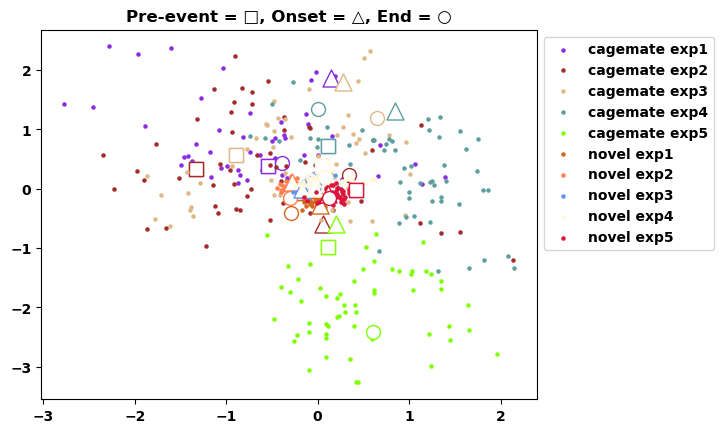

32_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


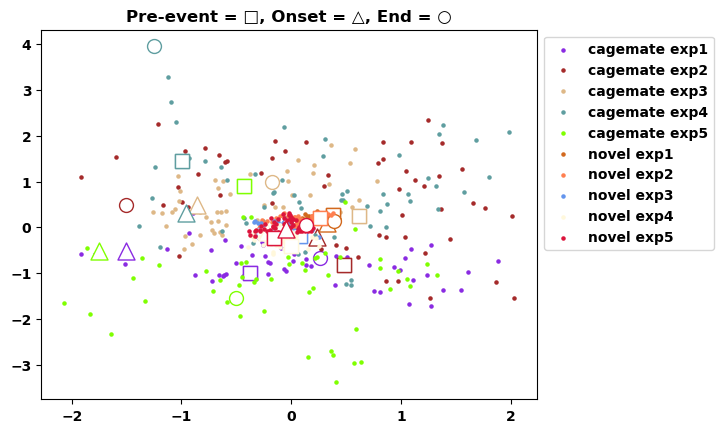

33_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


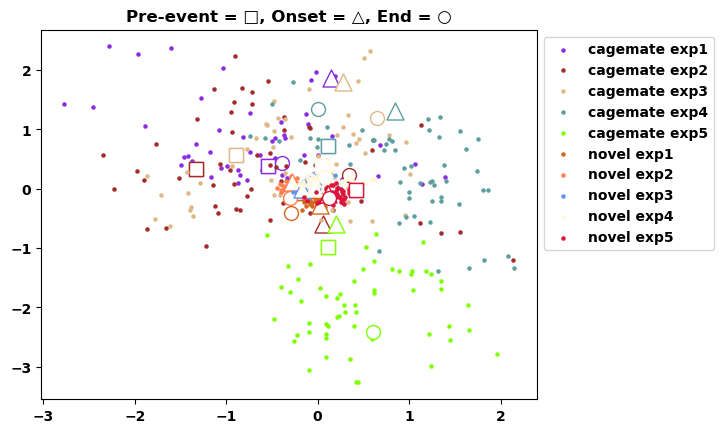

41_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


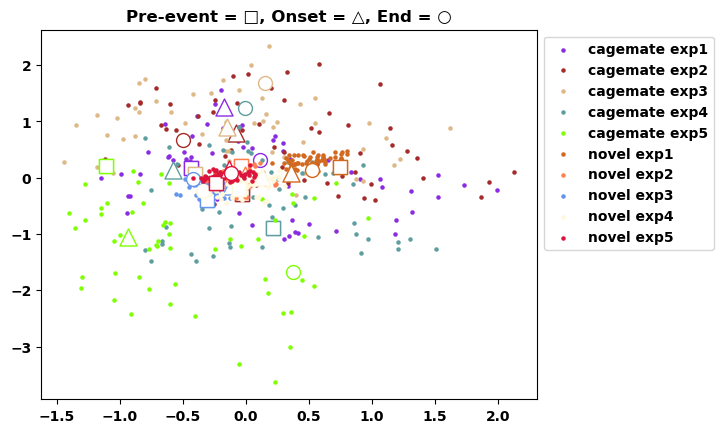

44_cage_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


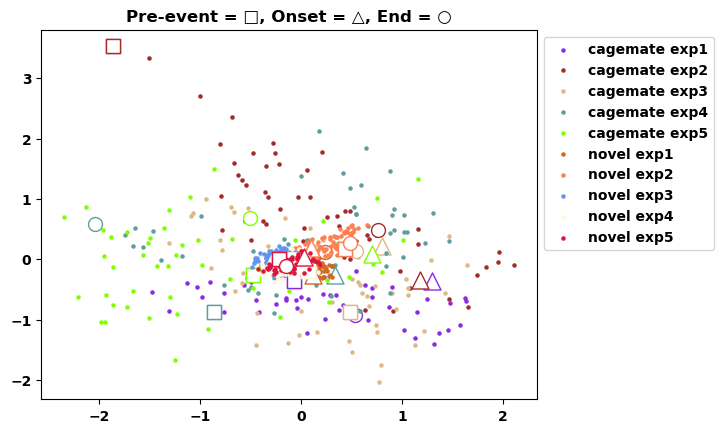

11_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


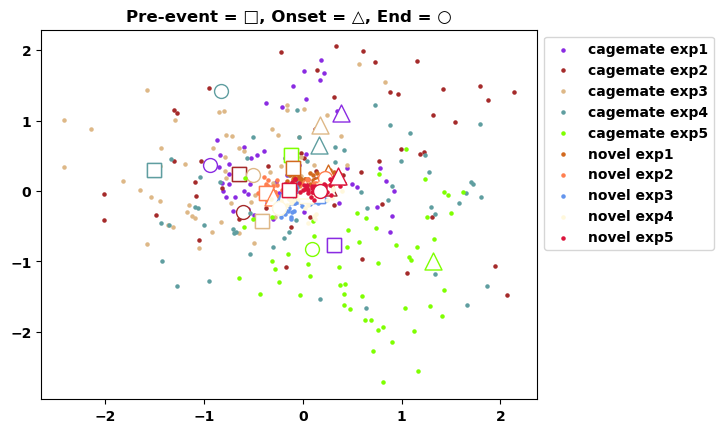

12_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


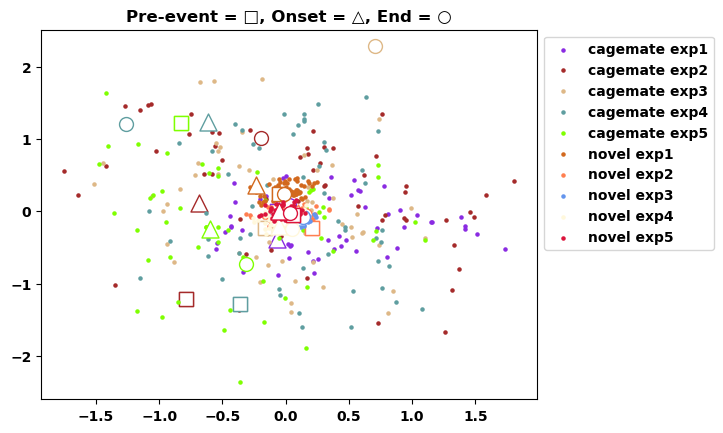

13_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


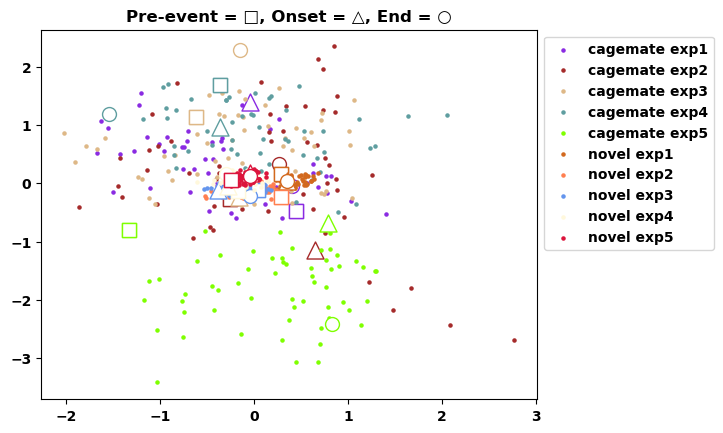

21_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


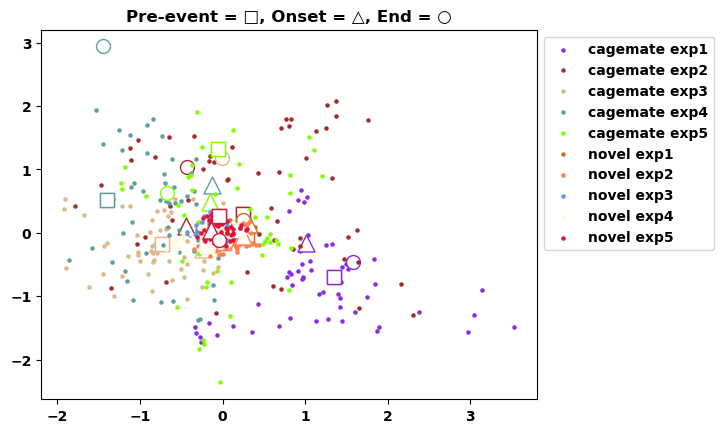

22_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


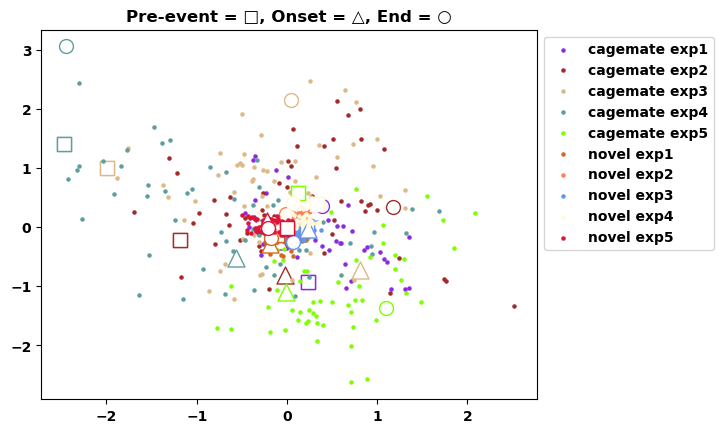

24_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


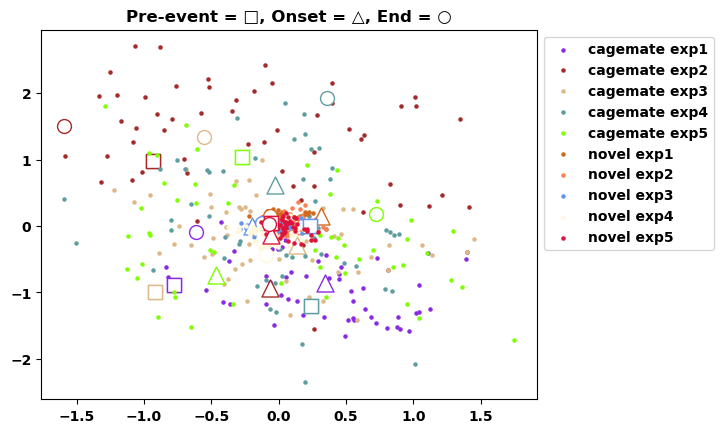

32_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


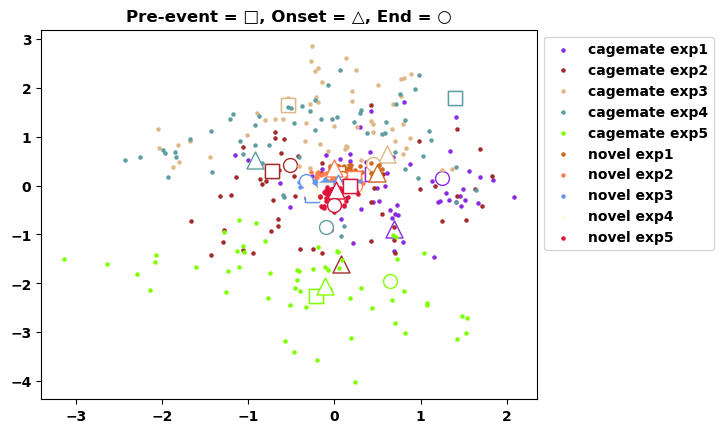

33_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons


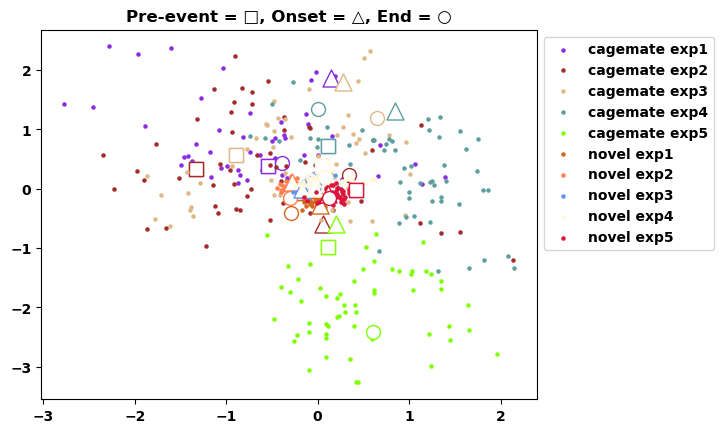

41_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


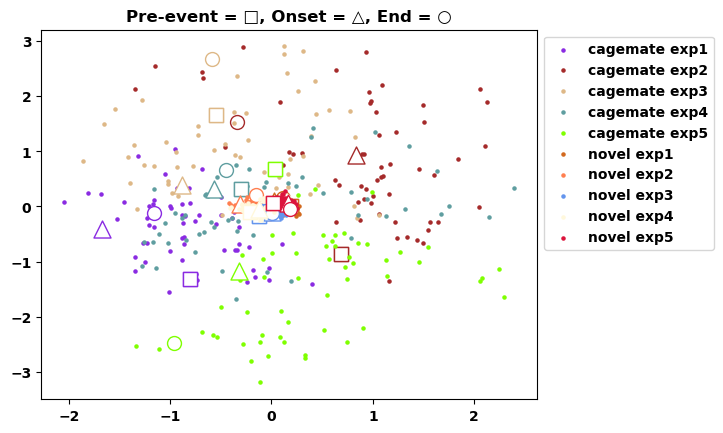

44_nov_p1_merged.rec
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


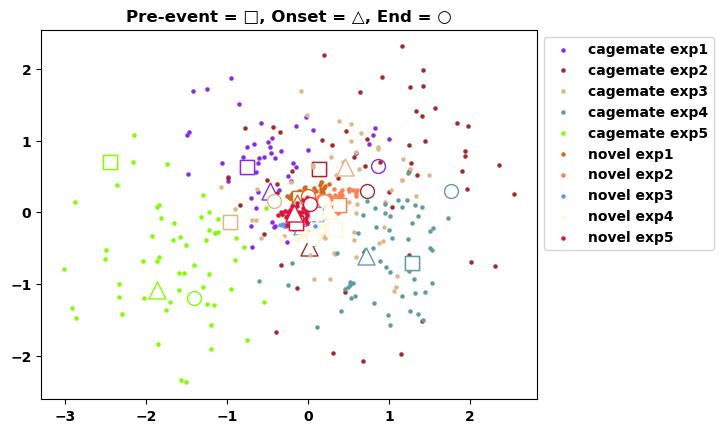

In [80]:
from importlib import reload
reload(pca_trajectories)
events = ['exp1', 'exp2', 'exp3', 'exp4', 'exp5']
#events = ['novel', 'not_novel']
event_length=3
pre_window = 3
post_window=0
min_neurons=5
plot= False

result_list = pca_trajectories.LOO_PCA(whole_collection, event_length=event_length, pre_window=pre_window, post_window=post_window, events=events, min_neurons= min_neurons, condition_dict=condition_dict, plot = True)

[200.42741262 252.21060837 248.66674714 190.34153869 282.99601917
 210.78401581]
['exp1_cagemate' 'exp4_cagemate' 'exp5_cagemate' 'exp1_novel' 'exp4_novel'
 'exp5_novel']


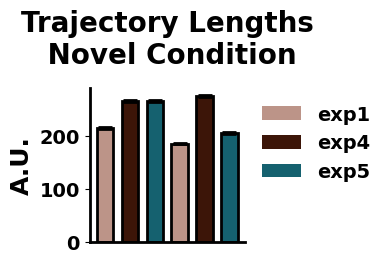

In [81]:
from scipy.spatial.distance import euclidean
from statsmodels.stats.multitest import multipletests
def condition_trajectory_length(pca_dict, key):
    trajectory_lengths = []
    event_order = []
    unique_values, counts = np.unique(key, return_counts=True)
    event_len = counts[0]
   
    for condition in pca_dict.keys():
        for j in range(0, len(key), event_len):
            trajectory_length = 0
            for i in range(event_len-1):
                trajectory_length = trajectory_length + euclidean(
                    pca_dict[condition][j+i, :],
                    pca_dict[condition][j+i+1, :])
            trajectory_lengths.append(trajectory_length)
            event_order.append(f"{key[j]}_{condition}")
    return [trajectory_lengths, event_order]


trajectory_lengths = []
orders= []
for loo_result in result_list:
    [traj_len, event_order] = condition_trajectory_length(loo_result.transformed_data, loo_result.labels)
    trajectory_lengths.append(traj_len)
    orders.append(event_order)
trajectory_lengths = np.array(trajectory_lengths)
print(np.array(trajectory_lengths[1])[[0,3,4,5,8,9]])
print(np.array(orders[1])[[0,3,4,5,8,9]])

means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,3,4,5,8,9]]
sems_for_plotting = sems[[0,3,4,5,8,9]]

# t_exp1_exp4, p_exp1_exp4 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,3])
# t_exp1_exp5, p_exp1_exp5 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,4])
# t_exp4_exp5, p_exp4_exp5 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,4])
# p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
# reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
# stats_df = pd.DataFrame({
#    'Comparison': ['exp1_exp4', 'exp1_exp5', 'exp4_exp5'],
#    't_statistic': [t_exp1_exp4, t_exp1_exp5, t_exp4_exp5],
#    'p_value': p_values,
#    'p_adjusted': p_adjusted,
#    'significant': reject
# })

# Adjust p-values using Holm-Bonferroni
# p_values = [p_exp1_exp4, p_exp1_exp5, p_exp4_exp5]
# reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
color_id_dict = {'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F'),
                  'exp1': hex_2_rgb('#bc9488'), 
                'exp4': hex_2_rgb('#3c1508'),
                  'exp5':  hex_2_rgb('#15616F')} 
  # Ensures bars don't overlap but aren't too thin
                                # Max width of 0.4 (your original), gets smaller with more bars

# Create evenly spaced x positions based on the number of data points
x = np.arange(len(means_for_plotting))
width = 4 / len(x)
plt.figure(figsize= (2,2))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(),
            edgecolor = 'black',
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = width)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label) for label, color in color_id_dict.items()]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(20))
#plt.ylim(40,100)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

#stats_df

In [82]:

def get_indices(repeated_items_list):
    """
    Takes in an indexed key or a list of repeated items,
    creates a list of indices that correspond to each unique item.

    Args (1):
        repeated_items_list: list, list of repeated items

    Returns:
        item_indices: list of tuples, where the first element
            is the first index of an item, and the second
            element is the last index of that item
    """
    is_first = True
    item_indices = []
    for i in range(len(repeated_items_list)):
        if is_first:
            current_item = repeated_items_list[i]
            start_index = 0
            is_first = False
        else:
            if repeated_items_list[i] == current_item:
                end_index = i
                if i == (len(repeated_items_list) - 1):
                    item_indices.append([start_index, end_index])
            else:
                item_indices.append([start_index, end_index])
                start_index = i
                current_item = repeated_items_list[i]
    return item_indices
    
def event_slice(transformed_subsets, key, no_PCs, mode):
    """
    Takes in a matrix T (session x timebins x pcs) (mode = 'multisession')
    or (timebins x pcs) (mode = 'single')
    and an event key to split the matrix by event and trim it to no_PCs.

    Args (3):
        transformed_subsets: np.array, d(session X timebin X PCS)
        key: list of str, each element is an event type and
            corresponds to the timebin dimension indices of
            the transformed_subsets matrix
        no_PCs: int, number of PCs required to explain a variance threshold
        mode: {'multisession', 'single'}; multisession calculates event slices
            for many transformed subsets, single calculates event slices for a
            single session
    Returns:
        trajectories: dict, events to trajectories across
            each LOO PCA embedding
            keys: str, event types
            values: np.array, d=(session x timebins x no_PCs)
    """
    event_indices = get_indices(key)
    events = np.unique(key)
    trajectories = {}
    for i in range(len(event_indices)):
        event = events[i]
        start = event_indices[i][0]
        stop = event_indices[i][1]
        if mode == "multisession":
            event_trajectory = transformed_subsets[:, start : stop + 1, :no_PCs]
        if mode == "single":
            event_trajectory = transformed_subsets[start : stop + 1, :no_PCs]
        trajectories[event] = event_trajectory
    return trajectories


def geodesic_distances(event_trajectories, mode):
    # Get all events
    events = list(event_trajectories.keys())
    
    # Initialize empty DataFrame with events as both rows and columns
    df = pd.DataFrame(index=events, columns=events)
    
    # Fill diagonal with zeros (distance to self is 0)
    for event in events:
        df.loc[event, event] = 0
    
    # Calculate distances for each pair
    pairs = list(combinations(events, 2))
    for pair in pairs:
        event1 = pair[0]
        event2 = pair[1]  # Only calculate each pair once
        dist = distance_bw_trajectories(
            event_trajectories[event1], 
            event_trajectories[event2], 
            mode
        )
        # Fill both symmetric positions in the DataFram
        converted_dist = float(np.mean(np.array(dist)))
        converted_sem = float(sem(np.array(dist)))
        # Fill both symmetric positions in the DataFrame
        df.loc[event1, event2] = converted_dist #converted_sem
        df.loc[event2, event1] = converted_dist #converted_sem

    return df

def distance_bw_trajectories(trajectory1, trajectory2, mode):
    if mode == "multisession":
        geodesic_distances = []
        for session in range(trajectory1.shape[0]):
            dist_bw_tb = 0
            for i in range(trajectory1.shape[1]):
                dist_bw_tb = dist_bw_tb + euclidean(trajectory1[session, i, :], trajectory2[session, i, :])
            geodesic_distances.append(dist_bw_tb)
    if mode == "single":
        dist_bw_tb = 0
        for i in range(trajectory1.shape[0]):
            dist_bw_tb = dist_bw_tb + euclidean(trajectory1[i, :], trajectory2[i, :])
        geodesic_distances = dist_bw_tb
    return geodesic_distances


def get_indices_claude(repeated_items_list):
    """
    Takes in a list of repeated items and returns start/end indices for each unique sequence.
    
    Args:
        repeated_items_list: list of repeated items
    
    Returns:
        list of [start_index, end_index] for each unique sequence
    """  
    result = []
    start = 0
    current = repeated_items_list[0]
    for i, item in enumerate(repeated_items_list[1:], 1):
        if item != current:
            result.append([start, i-1])
            start = i
            current = item    
    # Don't forget the last group
    result.append([start, len(repeated_items_list)-1])
    
    return result

In [ ]:
print(get_indices(master_key))
get_indices_claude(master_key)

[[0, 59], [60, 119], [120, 179], [180, 239], [240, 299], [300, 359], [360, 419], [420, 479], [480, 539], [540, 599]]


[[0, 59],
 [60, 119],
 [120, 179],
 [180, 239],
 [240, 299],
 [300, 359],
 [360, 419],
 [420, 479],
 [480, 539],
 [540, 599]]

In [ ]:
trajectory1 = np.array([
    # Session 1
    [[0],  # timepoint 1
     [1],  # timepoint 2
     [2]], # timepoint 3
    
    # Session 2
    [[0],
     [1],
     [2]]
])

trajectory2 = np.array([
    # Session 1
    [[1],  # timepoint 1
     [2],  # timepoint 2
     [3]], # timepoint 3
    
    # Session 2
    [[2],
     [4],
     [5]]
])

distance_bw_trajectories(trajectory1=trajectory1, trajectory2=trajectory2, mode = 'multisession')

[np.float64(3.0), np.float64(8.0)]

In [83]:
# no_PCs = PCs_needed(explained_variance_ratios, percent_var)
    # event_trajectories = event_slice(transformed_subsets, key, no_PCs, mode="multisession")
    # pairwise_distances = geodesic_distances(event_trajectories, mode="multisession")
#transformed_subsets = [sessions x 300 x 19]
cagemates = []
novels = []
for loo_result in result_list:
    cagemates.append(loo_result.transformed_data['cagemate'][:,:19])
    novels.append(loo_result.transformed_data['novel'][:,:19])
cagemates = np.stack(cagemates)
novels = np.stack(novels)

 
key = result_list[0].labels

prefix1 = "cagemate\n"
prefix2 = "novel\n"

list1 = [prefix1 + item for item in key]
list2 = [prefix2 + item for item in key]
master_key = list1 + list2


transformed_subsets = np.concatenate([cagemates, novels], axis = 1)

print(len(transformed_subsets.shape))
event_trajectories = event_slice(transformed_subsets, master_key, 3, 'multisession')


pairwise_distances = geodesic_distances(event_trajectories, mode="multisession")
pairwise_distances

3


,cagemate\nexp1,cagemate\nexp2,cagemate\nexp3,cagemate\nexp4,cagemate\nexp5,novel\nexp1,novel\nexp2,novel\nexp3,novel\nexp4,novel\nexp5
cagemate\nexp1,0,114.847196,107.959602,125.154375,142.786418,95.782579,84.501876,85.285551,84.830686,88.933045
cagemate\nexp2,114.847196,0,113.701634,118.183251,154.567399,99.721176,94.443543,93.621715,96.589299,96.786212
cagemate\nexp3,107.959602,113.701634,0,106.645828,153.339115,86.503684,87.046665,84.418714,85.445033,85.382349
cagemate\nexp4,125.154375,118.183251,106.645828,0,145.160331,93.412182,96.52405,96.913381,97.176131,91.228082
cagemate\nexp5,142.786418,154.567399,153.339115,145.160331,0,114.69742,117.686006,115.795469,120.351249,109.904859
novel\nexp1,95.782579,99.721176,86.503684,93.412182,114.69742,0,50.755281,59.786363,60.717576,47.631068
novel\nexp2,84.501876,94.443543,87.046665,96.52405,117.686006,50.755281,0,44.73162,47.783769,45.41336
novel\nexp3,85.285551,93.621715,84.418714,96.913381,115.795469,59.786363,44.73162,0,42.958156,42.557883
novel\nexp4,84.830686,96.589299,85.445033,97.176131,120.351249,60.717576,47.783769,42.958156,0,45.519674
novel\nexp5,88.933045,96.786212,85.382349,91.228082,109.904859,47.631068,45.41336,42.557883,45.519674,0


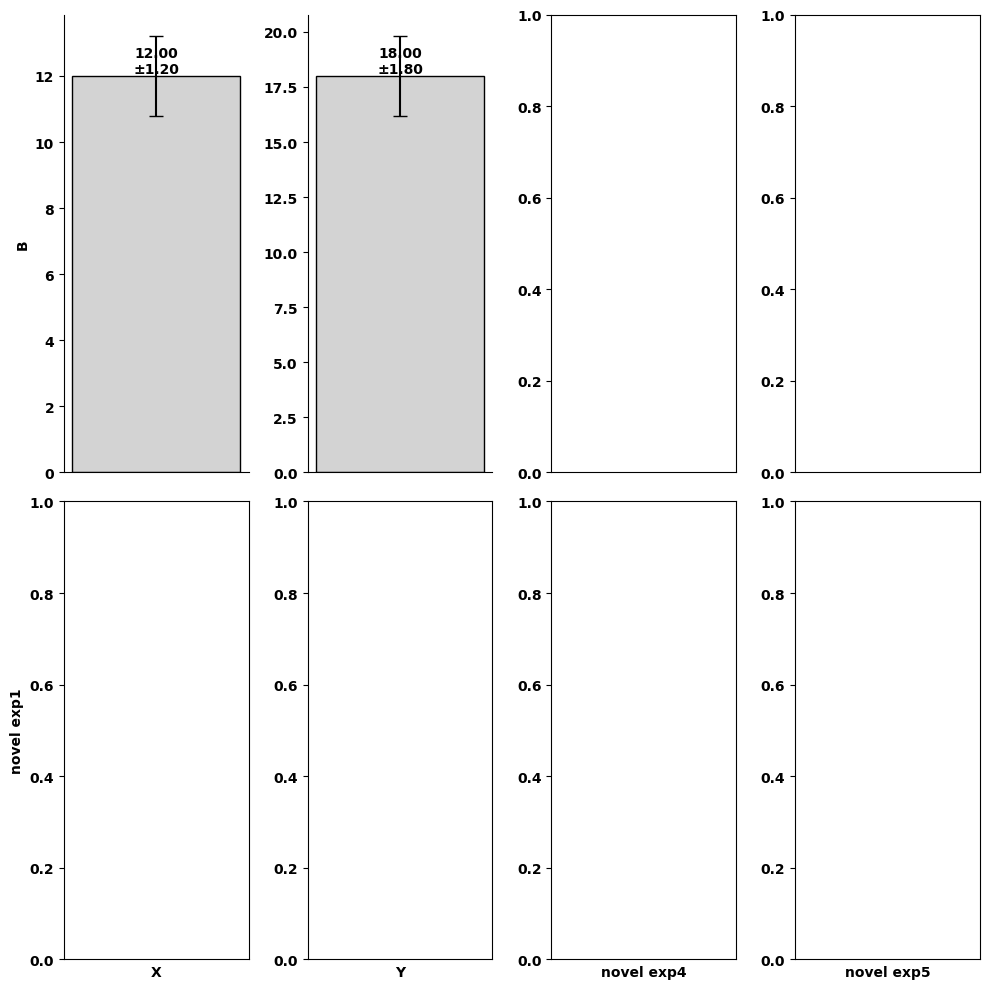

In [85]:
def plot_paired_bar_matrix(pairs, means, sems, figsize=(10,10)):
    """
    Create a matrix of bar plots where each cell shows mean ± SEM for a pair of conditions
    
    Parameters:
    pairs: List of lists, where each sublist contains [row_name, col_name]
    means: Dictionary with (row_name, col_name) tuples as keys and mean values
    sems: Dictionary with (row_name, col_name) tuples as keys and SEM values
    figsize: Tuple for figure size (width, height)
    """
    # Get unique row and column names
    row_names = sorted(list(set([pair[0] for pair in pairs])))
    col_names = sorted(list(set([pair[1] for pair in pairs])))
    
    # Create figure with subplot grid
    fig, axs = plt.subplots(len(row_names), len(col_names), 
                           figsize=figsize, 
                           squeeze=False)
    
    # Iterate through each subplot position
    for i, row in enumerate(row_names):
        for j, col in enumerate(col_names):
            ax = axs[i,j]
            
            # Check if this pair exists in our data
            if (row, col) in means:
                mean = means[(row, col)]
                sem = sems[(row, col)]
                
                # Create bar plot
                ax.bar([0], [mean], yerr=[sem], 
                      capsize=5, color='lightgray', 
                      edgecolor='black')
                
                # Add text for mean ± SEM
                ax.text(0, mean, f'{mean:.2f}\n±{sem:.2f}', 
                       ha='center', va='bottom')
                
                # Remove spines
                ax.spines['right'].set_visible(False)
                ax.spines['top'].set_visible(False)
                
            # Set labels and limits
            if i == len(row_names)-1:  # Bottom row
                ax.set_xlabel(col)
            if j == 0:  # First column
                ax.set_ylabel(row)
                
            # Remove ticks
            ax.set_xticks([])
    
    plt.tight_layout()
    return fig, axs

# Example usage:
pairs = [['novel exp1', 'novel exp4'], ['novel exp1', 'novel exp5'], ['B', 'X'], ['B', 'Y']]
means = {
    ('A', 'X'): 10, ('A', 'Y'): 15,
    ('B', 'X'): 12, ('B', 'Y'): 18
}
sems = {
    ('A', 'X'): 1, ('A', 'Y'): 1.5,
    ('B', 'X'): 1.2, ('B', 'Y'): 1.8
}

fig, axs = plot_paired_bar_matrix(pairs, means, sems)
plt.show()

In [86]:
def plot_comparison_heatmap(matrix, title, color, diagonal_color, vmin):
    # Create comparison matrix
    # Create figure
    
    # if matrix.index.dtype == 'object':
    #     matrix = matrix.set_index(matrix.columns[0])
    
    # Make sure all data columns are numeric
    matrix = matrix.astype(float)
    plt.figure(figsize=(5, 5))
    n_bins = 100  # Number of color gradients
    cmap = LinearSegmentedColormap.from_list('custom', color, N=n_bins)
    # Create heatmap
    
    sns.heatmap(matrix, 
                annot=True, 
                cmap=cmap,
                fmt='.0f',
                square=True,
                cbar_kws={'label': 'AU Distance', 'shrink': 0.8},
                vmin = vmin)
    if diagonal_color is not None:
        for i in range(len(matrix)):
            plt.plot(i + 0.5, i + 0.5, 'o', color=diagonal_color, markersize=25, zorder =100)
    
    plt.title(title, fontsize = 16)
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

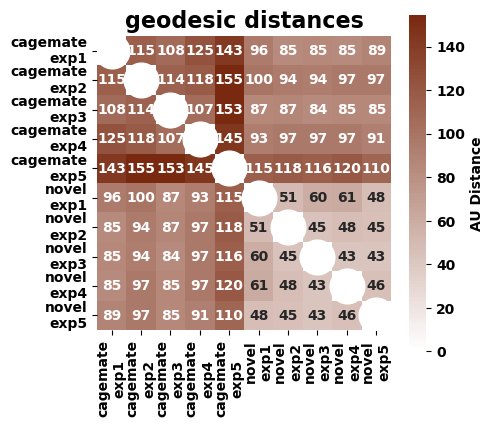

In [87]:
plot_comparison_heatmap(pairwise_distances, title = 'geodesic distances', color = ['white', '#792910'], diagonal_color='white', vmin = 0)

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

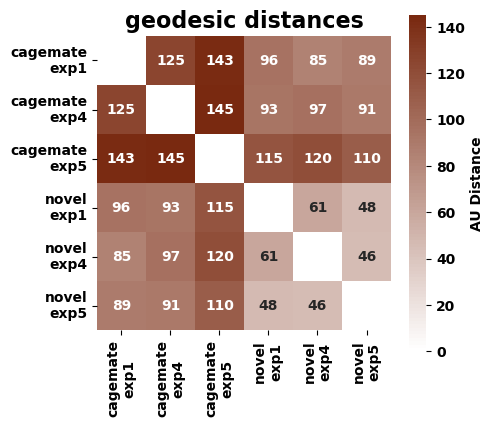

In [88]:
exp_filter = ['exp1', 'exp4', 'exp5']
mask = pairwise_distances.index.str.contains('|'.join(exp_filter))

# Apply mask to both rows and columns
filtered_df = pairwise_distances.loc[mask, mask]
#trimmed_pairwise = pairwise_distances[pairwise_distances[]]
filtered_df
plot_comparison_heatmap(filtered_df, title = 'geodesic distances', color = ['white', '#792910'], diagonal_color='white', vmin = 0)

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

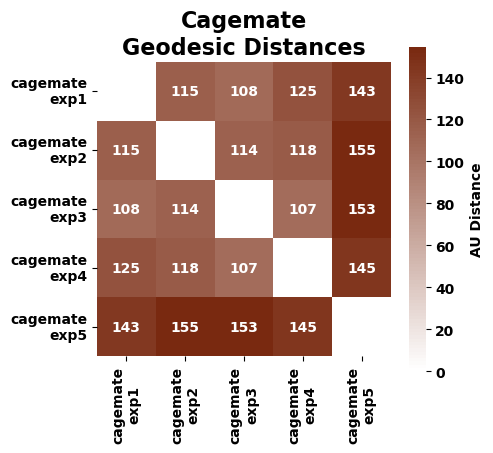

In [89]:
exp_filter = 'cagemate'
cage_mask = pairwise_distances.index.str.contains(exp_filter)

# Apply mask to both rows and columns
cagemate_df = pairwise_distances.loc[cage_mask, cage_mask]
plot_comparison_heatmap(cagemate_df, title = 'Cagemate\nGeodesic Distances', color = ['white', '#792910'], diagonal_color='white', vmin = 0)

<module 'matplotlib.pyplot' from 'c:\\Users\\megha\\anaconda3\\envs\\lfp_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

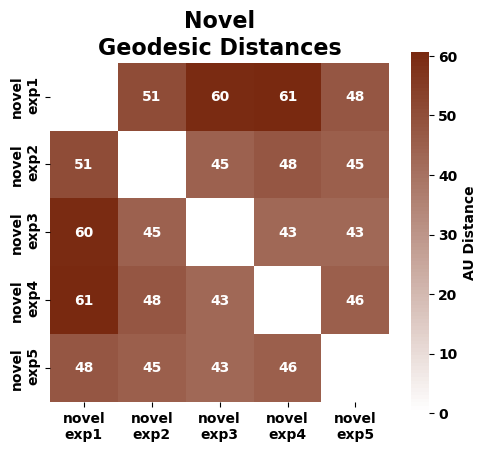

In [90]:
exp_filter = 'novel'
novel_mask = pairwise_distances.index.str.contains(exp_filter)

# Apply mask to both rows and columns
novel_df = pairwise_distances.loc[novel_mask, novel_mask]
plot_comparison_heatmap(novel_df, title = 'Novel\nGeodesic Distances', color = ['white', '#792910'], diagonal_color='white', vmin = 0)

,novel\nexp1,novel\nexp2,novel\nexp3,novel\nexp4,novel\nexp5
cagemate\nexp1,95.782579,84.501876,85.285551,84.830686,88.933045
cagemate\nexp2,99.721176,94.443543,93.621715,96.589299,96.786212
cagemate\nexp3,86.503684,87.046665,84.418714,85.445033,85.382349
cagemate\nexp4,93.412182,96.52405,96.913381,97.176131,91.228082
cagemate\nexp5,114.69742,117.686006,115.795469,120.351249,109.904859


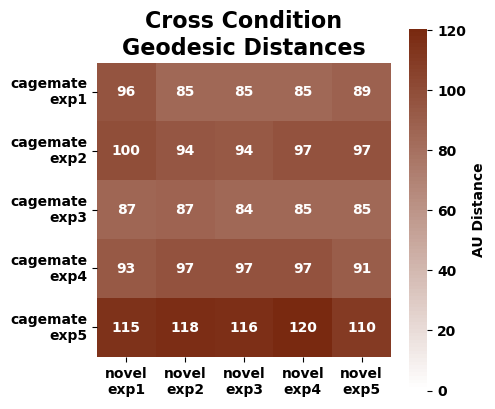

In [94]:


# Apply mask to both rows and columns
cross_df = pairwise_distances.loc[cage_mask, novel_mask]

plot_comparison_heatmap(cross_df, title = 'Cross Condition\nGeodesic Distances', color = ['white', '#792910'], diagonal_color=None, vmin = 0)
cross_df

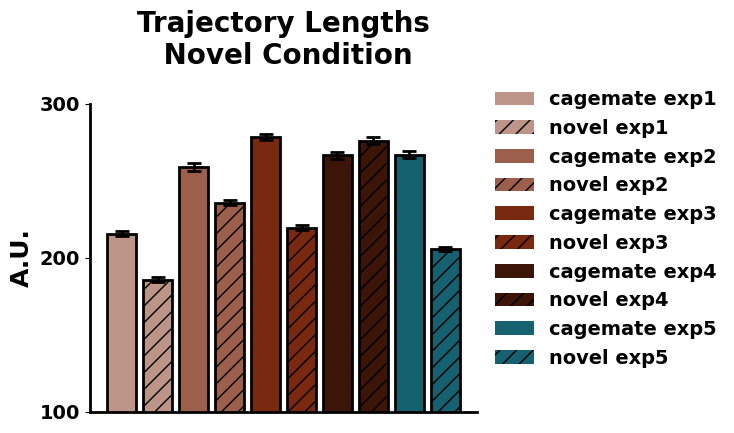

,Comparison,t_statistic,p_value,p_adjusted,significant
0,exp1,10.794980,8.610557e-10,2.583167e-09,True
1,exp2,6.303381,3.743239e-06,7.486478e-06,True
2,exp3,17.824654,9.611122e-14,3.844449e-13,True
3,exp4,-2.430334,2.462157e-02,2.462157e-02,True
4,exp5,19.224214,2.295203e-14,1.147602e-13,True


In [97]:
means = np.mean(trajectory_lengths, axis = 0)
sems = sem(trajectory_lengths, axis = 0)
means_for_plotting = means[[0,5,1,6,2,7,3,8,4,9]]
sems_for_plotting = sems[[0,5,1,6,2,7,3,8,4,9]]

t_exp1, p_exp1 = stats.ttest_rel(trajectory_lengths[:,0], trajectory_lengths[:,5])
t_exp4, p_exp4 = stats.ttest_rel(trajectory_lengths[:,3], trajectory_lengths[:,8])
t_exp5, p_exp5 = stats.ttest_rel(trajectory_lengths[:,4], trajectory_lengths[:,9])
t_exp2, p_exp2 = stats.ttest_rel(trajectory_lengths[:,1], trajectory_lengths[:,6])
t_exp3, p_exp3 = stats.ttest_rel(trajectory_lengths[:,2], trajectory_lengths[:,7])
p_values = [p_exp1, p_exp2, p_exp3, p_exp4, p_exp5]
reject, p_adjusted, _, _ = multipletests(p_values, method='holm')
stats_df = pd.DataFrame({
   'Comparison': ['exp1', 'exp2', 'exp3', 'exp4', 'exp5'],
   't_statistic': [t_exp1, t_exp2, t_exp3, t_exp4, t_exp5],
   'p_value': p_values,
   'p_adjusted': p_adjusted,
   'significant': reject
})

#Adjust p-values using Holm-Bonferroni

color_id_dict = {'cagemate exp1': hex_2_rgb('#bc9488'), 
                 'novel exp1': hex_2_rgb('#bc9488'), 
                 'cagemate exp2' :hex_2_rgb('#9b5f4c'),
                 'novel exp2' :hex_2_rgb('#9b5f4c'),
                 'cagemate exp3': hex_2_rgb('#792910'),
                 'novel exp3': hex_2_rgb('#792910'),
                'cagemate exp4': hex_2_rgb('#3c1508'),
                 'novel exp4': hex_2_rgb('#3c1508'),
                  'cagemate exp5':  hex_2_rgb('#15616F'),
                  'novel exp5':  hex_2_rgb('#15616F')}
  # Ensures bars don't overlap but aren't too thin
                                # Max width of 0.4 (your original), gets smaller with more bars

# Create evenly spaced x positions based on the number of data points
x = np.arange(len(means_for_plotting))
width = 8 / len(x)
hatches = ['','//']*5
plt.figure(figsize= (.5*len(x),4))           
plt.bar(x, means_for_plotting, yerr = sems_for_plotting,
            color = color_id_dict.values(),
            edgecolor = 'black',
            hatch = hatches,
            capsize = 5, linewidth = 2,
            error_kw={'elinewidth': 2, 'capthick': 2}, 
            width = width)
plt.xticks([],rotation=45)
legend_handles = [Patch(facecolor=color, label=label, hatch=hatch) 
                 for (label, color), hatch in zip(color_id_dict.items(), hatches)]
plt.legend(handles=legend_handles,
           bbox_to_anchor=(1,1.1),
           frameon= False, fontsize = 14)
plt.ylabel('A.U.', fontsize = 18)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
plt.ylim(100,300)
plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
plt.gca().spines['left'].set_linewidth(2) 
plt.title('Trajectory Lengths\n Novel Condition', fontsize = 20, y = 1.1)
plt.show()

stats_df

In [ ]:
condition_dict

{'cagemate': ['11_cage_p1_merged.rec',
  '12_cage_p1_merged.rec',
  '13_cage_p1_merged.rec',
  '21_cage_p1_merged.rec',
  '22_cage_p1_merged.rec',
  '24_cage_p1_merged.rec',
  '31_cage_p1_merged.rec',
  '32_cage_p1_merged.rec',
  '33_cage_p1_merged.rec',
  '41_cage_p1_merged.rec',
  '44_cage_p1_merged.rec'],
 'novel': ['11_nov_p1_merged.rec',
  '12_nov_p1_merged.rec',
  '13_nov_p1_merged.rec',
  '21_nov_p1_merged.rec',
  '22_nov_p1_merged.rec',
  '24_nov_p1_merged.rec',
  '32_nov_p1_merged.rec',
  '33_nov_p1_merged.rec',
  '41_nov_p1_merged.rec',
  '44_nov_p1_merged.rec']}

In [ ]:
from importlib import reload
import spike.spike_analysis.decoders as decoders
reload(pca_trajectories)
reload(decoders)
events = ['exp1', 'exp4', 'exp5']
#events = ['novel', 'not_novel']
event_length=5
pre_window = 5
post_window=0
min_neurons=5
plot= True
num_fold = 2
no_PCs = 3

decoder_data = decoders.trial_PCA(whole_collection,
                                     no_PCs = no_PCs,
                                     events = events,
                                     event_length=event_length,
                                     pre_window=pre_window,
                                     post_window=post_window,
                                     min_neurons= min_neurons,
                                     condition_dict=condition_dict)

decoder_data.keys()




<class 'dict'>
Excluding 31_cage_p1_merged.rec with 1 neurons
Excluding 33_cage_p1_merged.rec with 2 neurons
Excluding 33_nov_p1_merged.rec with 1 neurons


dict_keys(['cagemate exp1', 'cagemate exp4', 'cagemate exp5', 'novel exp1', 'novel exp4', 'novel exp5'])

In [ ]:
keys_wanted = ['cagemate exp1', 'novel exp1']
exp1_data = {k: decoder_data[k] for k in keys_wanted}

exp1_results = decoders.trial_decoder(whole_collection,
                                      num_fold = 5,
                                     no_PCs = no_PCs,
                                     events = keys_wanted,
                                     event_length=event_length,
                                     pre_window=pre_window,
                                     post_window=post_window,
                                     min_neurons= min_neurons, 
                                     decoder_data = exp1_data)

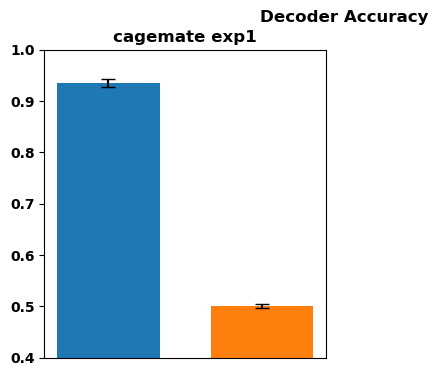

In [ ]:
exp1_results.plot_average()

In [ ]:
keys_wanted = ['cagemate exp4', 'novel exp4']
exp4_data = {k: decoder_data[k] for k in keys_wanted}

exp4_results = decoders.trial_decoder(whole_collection,
                                      num_fold = 5,
                                     no_PCs = no_PCs,
                                     events = keys_wanted,
                                     event_length=event_length,
                                     pre_window=pre_window,
                                     post_window=post_window,
                                     min_neurons= min_neurons, 
                                     decoder_data = exp4_data)

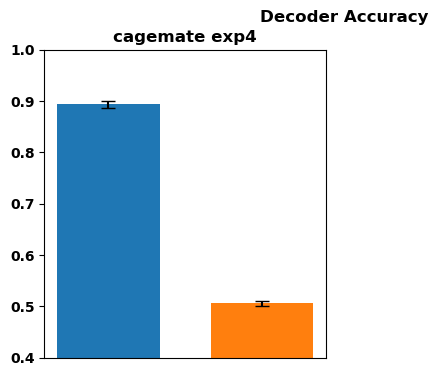

In [ ]:
exp4_results.plot_average()

In [ ]:
print(len(whole_collection.collection))
for recording in whole_collection.collection:
    print(recording.name)

21
11_cage_p1_merged.rec
12_cage_p1_merged.rec
13_cage_p1_merged.rec
21_cage_p1_merged.rec
22_cage_p1_merged.rec
24_cage_p1_merged.rec
31_cage_p1_merged.rec
32_cage_p1_merged.rec
33_cage_p1_merged.rec
41_cage_p1_merged.rec
44_cage_p1_merged.rec
11_nov_p1_merged.rec
12_nov_p1_merged.rec
13_nov_p1_merged.rec
21_nov_p1_merged.rec
22_nov_p1_merged.rec
24_nov_p1_merged.rec
32_nov_p1_merged.rec
33_nov_p1_merged.rec
41_nov_p1_merged.rec
44_nov_p1_merged.rec
